In [1]:
# set the environment of the game
import gym
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import tensorflow as tf
print(tf.__version__)

import random
from collections import deque
import matplotlib.pyplot as plt
import time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     #os.environ['CUDA_VISIBLE_DEVICES'] = '7'

1.15.3


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# set the environment of the game
env = gym.make('CartPole-v0')


In [4]:
# set up the training hyperparameters

state_size = 4 # our input is an observation with four elements
action_size = env.action_space.n  # number of actions (push to left or push to right)
possible_actions = np.identity(2, dtype = int).tolist()


# training hyperparameters
learning_rate = 0.001

number_epoch = 500 # number of epochs for training
batch_size = 1000 # defines number of samples work though

training = True 
hidden_size_1 = 53
hidden_size_2 = 34

max_steps = 200 # Max steps per episode



In [5]:
# calculate the discounted some of reward from current step onward
def discount_rewards(r, gamma = 0.95, normalization = False):
    discounted_r = np.zeros_like(r) #make a vector of zeros with the size of input
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    if normalization: # do normalization for reward to have more smooth gradient
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean)/(std)
        
    return discounted_r 


In [6]:
# define the policy network 

class PGNetwork():
    def __init__(self, state_size, action_size, learning_rate, hidden_size_1, hidden_size_2, name = 'PGNetwork'):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, state_size], name = 'inputs')
                self.actions = tf.placeholder(tf.int32, shape = [None, action_size], name = 'actions')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            
            # CNN is often used for image process, because here we are not dealing with image, we use general fully connected layers
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the hidden nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       

            with tf.name_scope('layer2'):
                # filters gives the number of filters in the hidden nn
                self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
                                             num_outputs = self.hidden_size_2,   
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())

 
            with tf.name_scope('logits'):
                # get the action distribution from the fully connected NN
                self.logits = tf.layers.dense(inputs = self.layer2,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.action_size, 
                                             activation = None)
                
            with tf.name_scope('softmax'):
                self.action_distribution = tf.nn.softmax(self.logits)
                
            # define the loss function
            with tf.name_scope('loss'):
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.actions)
                #self.log_action_probability = tf.nn.softmax_cross_entropy_with_logits(logits = self.outputlayer, labels = self.actions)
                self.weighted_likelihoods = tf.multiply(self.cross_entropy, self.discounted_episode_rewards)
                self.loss = tf.reduce_mean(self.weighted_likelihoods)
                
            with tf.name_scope('train'):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate,  beta1=0.9, beta2=0.99)
                self.train_opt = self.optimizer.minimize(self.loss)
            
            

In [51]:
# Value estimator network
class VENetwork():
    def __init__(self, state_size, learning_rate,  name = 'VENetwork'):
        
        self.state_size = state_size
        self.output_size = 1
        self.learning_rate = learning_rate
        self.hidden_size_1 = 16
        #self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, state_size], name = 'inputs')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            
            # CNN is often used for image process, because here we are not dealing with image, we use general fully connected layers
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the convolution nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       
            
            #with tf.name_scope('layer2'):
                # filters gives the number of filters in the convolution nn
            #    self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
            #                                 num_outputs = self.hidden_size_2,   
            #                                 activation_fn = tf.nn.elu,
            #                                 weights_initializer=tf.contrib.layers.xavier_initializer())
                
             
            with tf.name_scope('output'):
                # get the action distribution from the fully connected NN
                self.output_layer = tf.layers.dense(inputs = self.layer1,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.output_size, 
                                             activation = None)
                
                self.state_value_estimation = tf.squeeze(self.output_layer)
                
            # define the loss function
            with tf.name_scope('loss'):

                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards))
                
            with tf.name_scope('train'):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)

In [52]:
# sample from the environment 
# initialize network and session
tf.reset_default_graph()
PGN = PGNetwork(state_size, action_size, learning_rate, hidden_size_1, hidden_size_2)
VEN = VENetwork(state_size, learning_rate)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [53]:
# run the policy until it reached maximum batch number and outputs information of each step (batch number)
# for each episode
def make_batch(batch_size):
    states, actions, rewards_of_episode, rewards_of_batch,rewards_of_episode0, discounted_rewards = [],[],[],[],[],[]
    # keep track of how many episodes in our batch (useful when we need to calculate the average reward)
    episode_num = 1
    # get a new state
    state = env.reset()
   
    while True:
        
        action_probability_distribution = sess.run(PGN.action_distribution, feed_dict = {PGN.inputs: state.reshape(1, state_size)})
        state_value_estimation = sess.run(VEN.state_value_estimation, feed_dict = {VEN.inputs: state.reshape(1, state_size)})
        action = np.random.choice(range(action_probability_distribution.shape[1]), p = action_probability_distribution.ravel())
        next_state, reward, done, info = env.step(action)
        
        action_ = [0,0]
        action_[action] = 1
        
        states.append(state)
        actions.append(action_)
        rewards_of_episode.append(reward)
        rewards_of_episode0.append(reward-state_value_estimation)

        if done:
            rewards_of_batch.append(rewards_of_episode)
    
            discounted_rewards.append(discount_rewards(rewards_of_episode0, gamma = 0.95, normalization = True))
            
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            rewards_of_episode = []
            rewards_of_episode0 = []
            episode_num +=1
            
            state = env.reset()
        else:
            state = next_state

    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num


In [54]:
# training and print sth
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
average_reward = []
epoch = 1
# for plotting
epoch_1 = []
average_reward = []
saver = tf.train.Saver()
# while we have epoch/episode to train

if training:
    # number of iterations
    while epoch < number_epoch +1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size)
   
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        print('check',rewards_of_batch.shape, np.array(total_reward_of_that_batch).shape)
        allRewards.append(total_reward_of_that_batch)
        
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)
        maximumRewardRecorded = np.amax(allRewards)
        print('epoch',epoch)
        epoch_1.append(epoch)
        print('====================================')
        print("Epoch: ", epoch, '/', number_epoch)
        print('------------')
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward:{}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        loss_, cross, _= sess.run([PGN.loss, PGN.cross_entropy, PGN.train_opt],feed_dict = {PGN.inputs: states_mb.reshape([len(states_mb), state_size]), PGN.actions: actions_mb,PGN.discounted_episode_rewards: discounted_rewards_mb})    
        loss_VE, _= sess.run([VEN.loss, VEN.train_opt],feed_dict = {VEN.inputs: states_mb.reshape([len(states_mb), state_size]), VEN.discounted_episode_rewards: discounted_rewards_mb})    

        print('check',total_reward_of_that_batch)
        print('Training loss:{}'.format(loss_) )
        print('Cross Entropy:{}'.format(cross) )
        print('VE Training loss:{}'.format(loss_VE) )
              
        if epoch % 10 == 0:
              saver.save(sess, "./models/model.ckpt")
              print('Model saved')
        epoch += 1
        average_reward.append(mean_reward_of_that_batch)

check (1028,) ()
epoch 1
Epoch:  1 / 500
------------
Number of training episodes: 41
Total reward:1028.0
Mean Reward of that batch 25.073170731707318
Average Reward of all training: 25.073170731707318
Max reward for a batch so far: 1028.0
check 1028.0
Training loss:0.0067292326129972935
Cross Entropy:[0.6949106  0.71694565 0.69459105 ... 0.7402917  0.67389506 0.642808  ]
VE Training loss:1.0363086462020874
check (1002,) ()
epoch 2
Epoch:  2 / 500
------------
Number of training episodes: 43
Total reward:1002.0
Mean Reward of that batch 23.302325581395348
Average Reward of all training: 24.187748156551333
Max reward for a batch so far: 1028.0
check 1002.0
Training loss:-0.0003793962823692709
Cross Entropy:[0.6999422  0.6911365  0.67745197 ... 0.64025176 0.77001095 0.6368575 ]
VE Training loss:1.072463870048523
check (1011,) ()
epoch 3
Epoch:  3 / 500
------------
Number of training episodes: 48
Total reward:1011.0
Mean Reward of that batch 21.0625
Average Reward of all training: 23.145

check (1043,) ()
epoch 20
Epoch:  20 / 500
------------
Number of training episodes: 21
Total reward:1043.0
Mean Reward of that batch 49.666666666666664
Average Reward of all training: 34.14952092246762
Max reward for a batch so far: 1093.0
check 1043.0
Training loss:-0.0027646103408187628
Cross Entropy:[0.58640707 0.5555722  0.59223884 ... 0.76034594 1.1122868  1.5080118 ]
VE Training loss:1.0403532981872559
Model saved
check (1055,) ()
epoch 21
Epoch:  21 / 500
------------
Number of training episodes: 23
Total reward:1055.0
Mean Reward of that batch 45.869565217391305
Average Reward of all training: 34.707618269844936
Max reward for a batch so far: 1093.0
check 1055.0
Training loss:-0.0026362822391092777
Cross Entropy:[0.5280139  0.61956453 0.5116076  ... 0.46530277 0.74461997 0.39985812]
VE Training loss:1.1169158220291138
check (1024,) ()
epoch 22
Epoch:  22 / 500
------------
Number of training episodes: 23
Total reward:1024.0
Mean Reward of that batch 44.52173913043478
Average R

check (1169,) ()
epoch 39
Epoch:  39 / 500
------------
Number of training episodes: 11
Total reward:1169.0
Mean Reward of that batch 106.27272727272727
Average Reward of all training: 57.021449926653915
Max reward for a batch so far: 1169.0
check 1169.0
Training loss:-0.02011018991470337
Cross Entropy:[0.69413507 1.1257586  0.2180802  ... 0.11261839 1.9308714  0.0835974 ]
VE Training loss:1.083898901939392
check (1046,) ()
epoch 40
Epoch:  40 / 500
------------
Number of training episodes: 9
Total reward:1046.0
Mean Reward of that batch 116.22222222222223
Average Reward of all training: 58.501469234043135
Max reward for a batch so far: 1169.0
check 1046.0
Training loss:-0.030573656782507896
Cross Entropy:[0.7390274 1.1778281 0.2090649 ... 0.4119439 0.6231837 0.9098507]
VE Training loss:1.0924530029296875
Model saved
check (1146,) ()
epoch 41
Epoch:  41 / 500
------------
Number of training episodes: 9
Total reward:1146.0
Mean Reward of that batch 127.33333333333333
Average Reward of a

check (1014,) ()
epoch 58
Epoch:  58 / 500
------------
Number of training episodes: 6
Total reward:1014.0
Mean Reward of that batch 169.0
Average Reward of all training: 85.9897584755853
Max reward for a batch so far: 1169.0
check 1014.0
Training loss:-0.013449572958052158
Cross Entropy:[0.74079406 1.4036249  0.11906946 ... 0.74270093 0.28399792 0.5489378 ]
VE Training loss:1.0092222690582275
check (1128,) ()
epoch 59
Epoch:  59 / 500
------------
Number of training episodes: 8
Total reward:1128.0
Mean Reward of that batch 141.0
Average Reward of all training: 86.9221354505754
Max reward for a batch so far: 1169.0
check 1128.0
Training loss:-0.023851288482546806
Cross Entropy:[0.76364595 0.25603956 0.5633168  ... 0.10807535 0.19080973 1.2718754 ]
VE Training loss:1.007515549659729
check (1143,) ()
epoch 60
Epoch:  60 / 500
------------
Number of training episodes: 7
Total reward:1143.0
Mean Reward of that batch 163.28571428571428
Average Reward of all training: 88.19486176449438
Max r

check (1072,) ()
epoch 77
Epoch:  77 / 500
------------
Number of training episodes: 6
Total reward:1072.0
Mean Reward of that batch 178.66666666666666
Average Reward of all training: 107.228525555512
Max reward for a batch so far: 1169.0
check 1072.0
Training loss:-0.0005435610073618591
Cross Entropy:[0.7378892 1.5360596 0.087049  ... 0.5872363 0.298734  0.6922266]
VE Training loss:0.9872849583625793
check (1155,) ()
epoch 78
Epoch:  78 / 500
------------
Number of training episodes: 6
Total reward:1155.0
Mean Reward of that batch 192.5
Average Reward of all training: 108.32174958685158
Max reward for a batch so far: 1169.0
check 1155.0
Training loss:-0.00393707025796175
Cross Entropy:[0.75123614 1.4909959  0.09979896 ... 0.05738474 0.1218955  0.2663347 ]
VE Training loss:1.0344771146774292
check (1142,) ()
epoch 79
Epoch:  79 / 500
------------
Number of training episodes: 6
Total reward:1142.0
Mean Reward of that batch 190.33333333333334
Average Reward of all training: 109.359870900

check (1200,) ()
epoch 96
Epoch:  96 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 122.55036003138041
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004714453127235174
Cross Entropy:[0.8007611  0.19712652 0.89312476 ... 0.9375659  0.16374955 1.138126  ]
VE Training loss:0.9822216033935547
check (1008,) ()
epoch 97
Epoch:  97 / 500
------------
Number of training episodes: 6
Total reward:1008.0
Mean Reward of that batch 168.0
Average Reward of all training: 123.01891302074762
Max reward for a batch so far: 1200.0
check 1008.0
Training loss:-0.010838034562766552
Cross Entropy:[0.6284267  0.285923   0.7959713  ... 0.7400355  0.24963526 0.6480371 ]
VE Training loss:0.9047507047653198
check (1150,) ()
epoch 98
Epoch:  98 / 500
------------
Number of training episodes: 6
Total reward:1150.0
Mean Reward of that batch 191.66666666666666
Average Reward of all training: 123.71940030284883


check (1109,) ()
epoch 115
Epoch:  115 / 500
------------
Number of training episodes: 6
Total reward:1109.0
Mean Reward of that batch 184.83333333333334
Average Reward of all training: 133.45363388126827
Max reward for a batch so far: 1200.0
check 1109.0
Training loss:1.7762937204679474e-05
Cross Entropy:[0.7106867  0.22408581 0.6464306  ... 0.15821901 1.2752908  0.09046236]
VE Training loss:0.9598700404167175
check (1160,) ()
epoch 116
Epoch:  116 / 500
------------
Number of training episodes: 6
Total reward:1160.0
Mean Reward of that batch 193.33333333333334
Average Reward of all training: 133.96983818688955
Max reward for a batch so far: 1200.0
check 1160.0
Training loss:-0.001948269084095955
Cross Entropy:[0.6735107  0.24549735 0.65495044 ... 0.11383701 1.479311   2.7974143 ]
VE Training loss:0.9562765955924988
check (1131,) ()
epoch 117
Epoch:  117 / 500
------------
Number of training episodes: 6
Total reward:1131.0
Mean Reward of that batch 188.5
Average Reward of all training

check (1132,) ()
epoch 134
Epoch:  134 / 500
------------
Number of training episodes: 6
Total reward:1132.0
Mean Reward of that batch 188.66666666666666
Average Reward of all training: 142.3519992264616
Max reward for a batch so far: 1200.0
check 1132.0
Training loss:-0.025910843163728714
Cross Entropy:[0.82326186 0.19652134 0.5859445  ... 0.05998826 0.15297028 1.1246465 ]
VE Training loss:0.9691994786262512
check (1174,) ()
epoch 135
Epoch:  135 / 500
------------
Number of training episodes: 6
Total reward:1174.0
Mean Reward of that batch 195.66666666666666
Average Reward of all training: 142.7469226889816
Max reward for a batch so far: 1200.0
check 1174.0
Training loss:0.009621607139706612
Cross Entropy:[0.6775753  0.24802558 0.7352384  ... 0.12078979 1.1937082  0.12394488]
VE Training loss:0.9659517407417297
check (1200,) ()
epoch 136
Epoch:  136 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 14

check (1174,) ()
epoch 153
Epoch:  153 / 500
------------
Number of training episodes: 6
Total reward:1174.0
Mean Reward of that batch 195.66666666666666
Average Reward of all training: 148.908504769145
Max reward for a batch so far: 1200.0
check 1174.0
Training loss:-0.02022477053105831
Cross Entropy:[0.77927756 0.19377455 0.8176161  ... 0.53197896 0.29168996 0.6494969 ]
VE Training loss:0.9571539163589478
check (1179,) ()
epoch 154
Epoch:  154 / 500
------------
Number of training episodes: 6
Total reward:1179.0
Mean Reward of that batch 196.5
Average Reward of all training: 149.21754045246226
Max reward for a batch so far: 1200.0
check 1179.0
Training loss:-0.006249654106795788
Cross Entropy:[0.5663532  0.2997517  0.5212433  ... 0.40311927 0.99748117 1.9214089 ]
VE Training loss:0.9487678408622742
check (1154,) ()
epoch 155
Epoch:  155 / 500
------------
Number of training episodes: 6
Total reward:1154.0
Mean Reward of that batch 192.33333333333334
Average Reward of all training: 14

check (1076,) ()
epoch 172
Epoch:  172 / 500
------------
Number of training episodes: 6
Total reward:1076.0
Mean Reward of that batch 179.33333333333334
Average Reward of all training: 153.71318544387123
Max reward for a batch so far: 1200.0
check 1076.0
Training loss:-0.003270538290962577
Cross Entropy:[0.5203339  0.29378664 0.86797976 ... 0.14518872 1.0525761  0.14655045]
VE Training loss:0.9186097979545593
check (1062,) ()
epoch 173
Epoch:  173 / 500
------------
Number of training episodes: 6
Total reward:1062.0
Mean Reward of that batch 177.0
Average Reward of all training: 153.84779130835753
Max reward for a batch so far: 1200.0
check 1062.0
Training loss:0.012011063285171986
Cross Entropy:[0.7459697  0.20223421 0.6503798  ... 0.41314057 0.89540243 0.2167224 ]
VE Training loss:0.940028727054596
check (1121,) ()
epoch 174
Epoch:  174 / 500
------------
Number of training episodes: 6
Total reward:1121.0
Mean Reward of that batch 186.83333333333334
Average Reward of all training: 1

check (1144,) ()
epoch 191
Epoch:  191 / 500
------------
Number of training episodes: 6
Total reward:1144.0
Mean Reward of that batch 190.66666666666666
Average Reward of all training: 156.95899422170604
Max reward for a batch so far: 1200.0
check 1144.0
Training loss:-0.0028214554768055677
Cross Entropy:[0.61974615 0.24710989 0.59379023 ... 1.0579131  0.12846322 1.2210128 ]
VE Training loss:0.9285492897033691
check (1181,) ()
epoch 192
Epoch:  192 / 500
------------
Number of training episodes: 6
Total reward:1181.0
Mean Reward of that batch 196.83333333333334
Average Reward of all training: 157.16667307124575
Max reward for a batch so far: 1200.0
check 1181.0
Training loss:0.0007132324972189963
Cross Entropy:[0.5885524  0.25078857 0.6090099  ... 0.2614068  0.63253623 0.2718841 ]
VE Training loss:0.981525719165802
check (1168,) ()
epoch 193
Epoch:  193 / 500
------------
Number of training episodes: 6
Total reward:1168.0
Mean Reward of that batch 194.66666666666666
Average Reward of 

check (1184,) ()
epoch 210
Epoch:  210 / 500
------------
Number of training episodes: 6
Total reward:1184.0
Mean Reward of that batch 197.33333333333334
Average Reward of all training: 160.52064077625008
Max reward for a batch so far: 1200.0
check 1184.0
Training loss:-0.004868335090577602
Cross Entropy:[0.75998676 1.6496638  0.06916384 ... 1.1146573  0.09892675 1.6232429 ]
VE Training loss:0.9711143970489502
Model saved
check (1200,) ()
epoch 211
Epoch:  211 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 160.70774674413516
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.00675421254709363
Cross Entropy:[0.8561737  0.1691455  0.919852   ... 0.41483006 0.38186666 0.43766946]
VE Training loss:1.0215065479278564
check (1200,) ()
epoch 212
Epoch:  212 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 16

check (1180,) ()
epoch 229
Epoch:  229 / 500
------------
Number of training episodes: 6
Total reward:1180.0
Mean Reward of that batch 196.66666666666666
Average Reward of all training: 163.3136880480896
Max reward for a batch so far: 1200.0
check 1180.0
Training loss:0.012485774233937263
Cross Entropy:[0.6910589  0.21544002 0.7490305  ... 0.3742536  0.41583183 0.56020075]
VE Training loss:0.9530219435691833
check (1164,) ()
epoch 230
Epoch:  230 / 500
------------
Number of training episodes: 6
Total reward:1164.0
Mean Reward of that batch 194.0
Average Reward of all training: 163.44710679570662
Max reward for a batch so far: 1200.0
check 1164.0
Training loss:-0.008193887770175934
Cross Entropy:[0.89338183 0.15326467 0.45949057 ... 0.18489926 0.62229747 0.2353302 ]
VE Training loss:0.9432901740074158
Model saved
check (1175,) ()
epoch 231
Epoch:  231 / 500
------------
Number of training episodes: 6
Total reward:1175.0
Mean Reward of that batch 195.83333333333334
Average Reward of all

check (1200,) ()
epoch 248
Epoch:  248 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 165.8770210874161
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.019271310418844223
Cross Entropy:[0.70500195 0.20107557 0.7260556  ... 1.6246624  0.05459621 0.16785735]
VE Training loss:0.9972675442695618
check (1200,) ()
epoch 249
Epoch:  249 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 166.0140611633702
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.005751046352088451
Cross Entropy:[0.46848983 0.3357164  1.0608981  ... 0.46601075 0.34209624 1.0095166 ]
VE Training loss:1.012027621269226
check (1200,) ()
epoch 250
Epoch:  250 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 166.15000491871672
Max rewar

check (1200,) ()
epoch 267
Epoch:  267 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.15605953687586
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.00366887915879488
Cross Entropy:[0.6950828  0.2007609  0.62130463 ... 0.07284842 0.28240633 0.52356076]
VE Training loss:0.9842110276222229
check (1200,) ()
epoch 268
Epoch:  268 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.27488021024573
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0022394387051463127
Cross Entropy:[0.7708742  0.15891778 0.83327043 ... 0.2583155  0.50551367 0.31176725]
VE Training loss:1.0349596738815308
check (1200,) ()
epoch 269
Epoch:  269 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.39281745853478
Max rew

check (1200,) ()
epoch 286
Epoch:  286 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 170.1235474231207
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.003728570183739066
Cross Entropy:[0.65642726 0.20016816 0.67206156 ... 0.23446363 0.8311931  1.9739044 ]
VE Training loss:0.9813210964202881
check (1096,) ()
epoch 287
Epoch:  287 / 500
------------
Number of training episodes: 6
Total reward:1096.0
Mean Reward of that batch 182.66666666666666
Average Reward of all training: 170.16725167135604
Max reward for a batch so far: 1200.0
check 1096.0
Training loss:0.016981318593025208
Cross Entropy:[0.6016152  0.22819307 0.61461985 ... 0.79723704 0.18074073 0.8055097 ]
VE Training loss:0.9863051772117615
check (1200,) ()
epoch 288
Epoch:  288 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 170.27083760305

check (1200,) ()
epoch 305
Epoch:  305 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 171.89344665468585
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0026046722196042538
Cross Entropy:[0.69062    0.22401169 0.7670766  ... 0.11596071 0.3954147  0.38719264]
VE Training loss:0.9749867916107178
check (1200,) ()
epoch 306
Epoch:  306 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 171.98529813620647
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.005780340638011694
Cross Entropy:[0.5235062  0.3406339  0.4818951  ... 1.4476554  0.07237981 0.14388272]
VE Training loss:1.0001882314682007
check (1200,) ()
epoch 307
Epoch:  307 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 172.07655123674002
Max re

check (1125,) ()
epoch 324
Epoch:  324 / 500
------------
Number of training episodes: 6
Total reward:1125.0
Mean Reward of that batch 187.5
Average Reward of all training: 173.2561766348123
Max reward for a batch so far: 1200.0
check 1125.0
Training loss:0.012615768238902092
Cross Entropy:[0.77538145 0.22079103 0.560025   ... 0.32002345 0.65218335 0.2535715 ]
VE Training loss:0.9510459899902344
check (1200,) ()
epoch 325
Epoch:  325 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 173.3384653220898
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.008348347619175911
Cross Entropy:[0.8052609  0.22890534 0.61498713 ... 1.4309262  0.10751367 0.3254831 ]
VE Training loss:0.9893689751625061
check (1200,) ()
epoch 326
Epoch:  326 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 173.42024917079505
Max reward

check (1200,) ()
epoch 343
Epoch:  343 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.52700622286034
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004519718699157238
Cross Entropy:[0.68989533 1.5087637  2.5040486  ... 0.6732346  1.2966617  0.12594414]
VE Training loss:0.9203617572784424
check (1200,) ()
epoch 344
Epoch:  344 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.60105562337526
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004547474440187216
Cross Entropy:[0.5218447 1.1454923 1.9799428 ... 0.3078931 0.7481061 0.2525732]
VE Training loss:0.9420560598373413
check (1200,) ()
epoch 345
Epoch:  345 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.67467575200317
Max reward for

check (1200,) ()
epoch 362
Epoch:  362 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.8234709054542
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.001080106943845749
Cross Entropy:[0.5590471  0.35754752 0.64915955 ... 1.5876428  0.08489294 0.14147447]
VE Training loss:0.9496296048164368
check (1200,) ()
epoch 363
Epoch:  363 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.8900729139791
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.007535476703196764
Cross Entropy:[0.68845856 0.3078575  0.68847287 ... 2.1005445  0.04597885 0.0690725 ]
VE Training loss:0.9432631134986877
check (1200,) ()
epoch 364
Epoch:  364 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.95630897740224
Max reward

check (1200,) ()
epoch 381
Epoch:  381 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 176.80733981043156
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.011698850430548191
Cross Entropy:[0.59472847 1.1016847  0.19257784 ... 0.19203444 0.3978257  0.6180343 ]
VE Training loss:0.9443707466125488
check (1128,) ()
epoch 382
Epoch:  382 / 500
------------
Number of training episodes: 6
Total reward:1128.0
Mean Reward of that batch 188.0
Average Reward of all training: 176.83663996799586
Max reward for a batch so far: 1200.0
check 1128.0
Training loss:0.009476106613874435
Cross Entropy:[0.4070606  0.5967596  1.1024557  ... 0.28862214 0.9518056  0.24187551]
VE Training loss:0.9454041719436646
check (1099,) ()
epoch 383
Epoch:  383 / 500
------------
Number of training episodes: 6
Total reward:1099.0
Mean Reward of that batch 183.16666666666666
Average Reward of all training: 176.853167452

check (1200,) ()
epoch 400
Epoch:  400 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.37565783610273
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0006319443346001208
Cross Entropy:[0.6516976  0.3935681  0.67606634 ... 0.32965788 0.59045005 0.46019083]
VE Training loss:0.9561377763748169
Model saved
check (1200,) ()
epoch 401
Epoch:  401 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.43207764199772
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.007370618171989918
Cross Entropy:[0.7526746  1.2633947  0.16261615 ... 0.40139747 0.77589333 0.29973596]
VE Training loss:1.0148626565933228
check (1200,) ()
epoch 402
Epoch:  402 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.488216752

check (1200,) ()
epoch 419
Epoch:  419 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.0992755794139
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.011900408193469048
Cross Entropy:[0.6350927  1.2053525  0.15847105 ... 0.6172737  1.2123246  0.13729301]
VE Training loss:0.9679028391838074
check (1200,) ()
epoch 420
Epoch:  420 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.15142016136767
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0013401213800534606
Cross Entropy:[0.83728087 1.6018106  0.08347283 ... 0.18710592 0.3669547  0.6878756 ]
VE Training loss:0.9665055274963379
Model saved
check (1200,) ()
epoch 421
Epoch:  421 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.2033170255

check (1200,) ()
epoch 438
Epoch:  438 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.98461902840432
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.002897935686632991
Cross Entropy:[0.37784377 0.857779   0.23083976 ... 0.34191784 0.8300946  1.6173806 ]
VE Training loss:0.9745643138885498
check (1200,) ()
epoch 439
Epoch:  439 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.03249005567446
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.011899157427251339
Cross Entropy:[0.5775623  0.33244002 0.7861768  ... 0.23028183 0.47263953 0.5109935 ]
VE Training loss:1.004057765007019
check (1200,) ()
epoch 440
Epoch:  440 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.08014348736612
Max rewar

check (1200,) ()
epoch 457
Epoch:  457 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.8185918332044
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0030764976982027292
Cross Entropy:[0.39279258 0.55666435 0.35214978 ... 0.14687523 1.161823   0.15596227]
VE Training loss:0.9407721161842346
check (1200,) ()
epoch 458
Epoch:  458 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.86265604317558
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.005504713859409094
Cross Entropy:[0.56316453 1.135895   0.16478261 ... 0.11216615 0.21921328 0.41874686]
VE Training loss:0.9326401948928833
check (1200,) ()
epoch 459
Epoch:  459 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.90652825223185
Max rewa

check (1200,) ()
epoch 476
Epoch:  476 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 180.61539874182304
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.011585857719182968
Cross Entropy:[0.8247249  0.22709748 0.5689227  ... 0.18191074 0.38635945 0.6174105 ]
VE Training loss:0.924801230430603
check (1168,) ()
epoch 477
Epoch:  477 / 500
------------
Number of training episodes: 6
Total reward:1168.0
Mean Reward of that batch 194.66666666666666
Average Reward of all training: 180.6448563265711
Max reward for a batch so far: 1200.0
check 1168.0
Training loss:-0.0004931018920615315
Cross Entropy:[0.8502166  0.21590006 0.54750115 ... 2.5569952  0.02396497 0.03710729]
VE Training loss:0.9765118956565857
check (1200,) ()
epoch 478
Epoch:  478 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 180.685348258

check (1200,) ()
epoch 495
Epoch:  495 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.3220804062783
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0039510042406618595
Cross Entropy:[0.6684302  0.28378874 0.7311922  ... 0.07962484 0.14701273 0.27921763]
VE Training loss:1.020334243774414
check (1200,) ()
epoch 496
Epoch:  496 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.3597375022334
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.003392260055989027
Cross Entropy:[0.6695649  0.30122763 0.6561282  ... 0.4801795  0.38902536 0.82368636]
VE Training loss:0.9883935451507568
check (1200,) ()
epoch 497
Epoch:  497 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.397243060579
Max reward f

Text(0,0.5,'average_reward_each_episode')

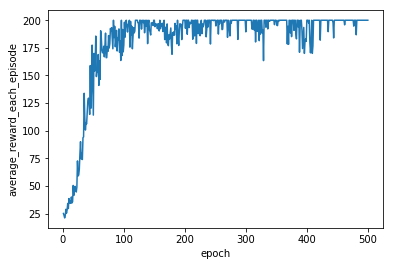

In [55]:

plt.plot(epoch_1, average_reward)
plt.xlabel('epoch')
plt.ylabel('average_reward_each_episode')

# Pong game

In [3]:
# set the environment of the game
import gym
env = gym.make('Pong-v0')

env.action_space.n
env.unwrapped.get_action_meanings()

# our agents only care about left and right move
Right_ACTION = 2
Left_ACTION = 3
action_dict = { 0:Right_ACTION, 1:Left_ACTION}
action_dict

{0: 2, 1: 3}

In [4]:


# set up the training hyperparameters

state_size = [80,80,1] # our input an image
action_size = 2  # number of actions (push to left or push to right)
#action_size = 1  # number of actions (push to left or push to right)
# training hyperparameters
learning_rate = 0.0001

number_epoch = 10000 # number of epochs for training
batch_size = 100 # defines number of samples work though
hidden_size_1 = 53
hidden_size_2 = 34

training = True 


max_steps = 200 # Max steps per episode




In [5]:
# calculate the discounted some of reward from current step onward
def discount_rewards(r, gamma = 0.99, normalization = False):
    discounted_r = np.zeros_like(r) #make a vector of zeros with the size of input
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    if normalization: # do normalization for reward to have more smooth gradient
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean)/(std)
        
    return discounted_r


In [6]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [7]:
# define the policy network 

class PGNetwork():
    def __init__(self, state_size, action_size, learning_rate, hidden_size_1, hidden_size_2, name = 'PGNetwork'):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        #self.hidden_size_1 = hidden_size_1
        self.hidden_size_1 = 53
        self.hidden_size_2 = 34
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, *state_size], name = 'inputs')
                self.actions = tf.placeholder(tf.int32, shape = [None, action_size], name = 'actions')
                #self.actions = tf.placeholder(tf.float32, shape = [None, action_size], name = 'actions')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            # CNN is often used for image process
            #with tf.name_scope('conv_layer1'):
              
                # filters gives the number of filters in the convolution nn
            #    self.conv1 = tf.layers.conv2d(inputs = self.inputs,
            #                    filters = 32,
            #                    kernel_size = [3,3],
            #                    strides = [1,1],
            #                    padding = 'VALID',
            #                    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), name = 'conv1')
                
            #    self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1, training = True,
            #                                                epsilon = 1e-5, name = 'batch_norm1')
            #    
            #    self.conv1_out = tf.nn.relu(self.conv1_batchnorm, name = 'conv1_out')
            
                
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the hidden nn
                #self.flatten = tf.contrib.layers.flatten(self.conv1_out)
                self.flatten = tf.contrib.layers.flatten(self.inputs)
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.flatten,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
            with tf.name_scope('layer2'):
                # filters gives the number of filters in the hidden nn
                self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
                                             num_outputs = self.hidden_size_2,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       
                                          
            with tf.name_scope('logits'):
                # get the action distribution from the fully connected NN
                self.logits = tf.layers.dense(inputs = self.layer2,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.action_size, 
                                             # units = 1, 
                                             activation = None)
            
               
                #self.out = tf.sigmoid(self.logits, name="sigmoid")
                
            with tf.name_scope('softmax'):
                self.action_distribution = tf.nn.softmax(self.logits)
                
            # define the loss function
            with tf.name_scope('loss'):
                #self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits( labels = self.actions,logits = self.logits)
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions)
                #self.log_action_probability = tf.nn.softmax_cross_entropy_with_logits(logits = self.outputlayer, labels = self.actions)
                self.weighted_likelihoods = tf.multiply(self.cross_entropy, self.discounted_episode_rewards)
                self.loss = tf.reduce_mean(self.weighted_likelihoods)

            with tf.name_scope('train'):
                #self.optimizer = tf.train.RMSPropOptimizer(1e-3, decay = 0.99)
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate,  beta1=0.9, beta2=0.99)
                self.train_opt = self.optimizer.minimize(self.loss)
            
            

In [8]:
# Value estimator network
class VENetwork():
    def __init__(self, state_size, learning_rate,  name = 'VENetwork'):
        
        self.state_size = state_size
        self.output_size = 1
        self.learning_rate = learning_rate
        self.hidden_size_1 = 150
        #self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, *state_size], name = 'inputs')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
                
            #  we use general fully connected layers
            with tf.name_scope('layer1'):
              
                self.inputs1 = tf.contrib.layers.flatten(self.inputs)
                # filters gives the number of filters in the convolution nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs1,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                        
            with tf.name_scope('output'):
                # get the action distribution from the fully connected NN
                self.output_layer = tf.layers.dense(inputs = self.layer1,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.output_size, 
                                             activation = None)
                
                self.state_value_estimation = tf.squeeze(self.output_layer)
                
            # define the loss function
            with tf.name_scope('loss'):

                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards))
                
           
                
            with tf.name_scope('train'):
                #self.optimizer = tf.train.RMSPropOptimizer(1e-3, decay = 0.99)
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)

In [9]:
# sample from the environment 
# initialize network and session
tf.reset_default_graph()
PGN = PGNetwork(state_size, action_size, learning_rate,hidden_size_1, hidden_size_2)
VEN = VENetwork(state_size, learning_rate)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [10]:
# run the policy until it reached maximum batch number and outputs information of each step (batch number)
# for each episode
def make_batch(batch_size):
    states, actions, rewards_of_episode, rewards_of_batch, rewards_of_episode0, discounted_rewards, discounted_rewards_est = [],[],[], [], [],[], []
    
    # keep track of how many episodes in our batch (useful when we need to calculate the average reward)
    episode_num = 1
    
    # get a new state
    state = env.reset()
    #state = preprocess(state)
    while True:
        state = preprocess(state)
        action_probability_distribution = sess.run(PGN.action_distribution, feed_dict = {PGN.inputs: state.reshape(1,*state_size)})
        #action_probability = sess.run(PGN.out, feed_dict = {PGN.inputs: state.reshape(1,*state_size)})
        state_value_estimation = sess.run(VEN.state_value_estimation, feed_dict = {VEN.inputs: state.reshape(1,*state_size)})
        #action_probability = action_probability[0][0]
                                                                                      
        action = np.random.choice(range(action_probability_distribution.shape[1]), p = action_probability_distribution.ravel())
        #action = np.random.choice(range(2,4), p = [1-action_probability, action_probability])
        action_ = [0,0]
        action_[action] = 1
        
        action = action_dict[action]
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action_)
        rewards_of_episode.append(reward)
        rewards_of_episode0.append(reward-state_value_estimation)
        
        if done:
            rewards_of_batch.append(rewards_of_episode)
            discounted_rewards.append(discount_rewards(rewards_of_episode0, gamma = 0.99, normalization = True))
            #discounted_rewards_est.append(discount_rewards(rewards_of_episode, gamma = 0.99, normalization = False))
            
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            rewards_of_episode = []
            rewards_of_episode0 = []
            episode_num +=1
            
            state = env.reset()
        else:
            state = next_state
    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num



In [11]:
# training and print sth
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
average_reward = []
epoch = 1
# for plotting
epoch_1 = []
saver = tf.train.Saver()
# while we have epoch/episode to train

In [14]:
if training:
    # number of iterations
    while epoch < number_epoch +1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size)
        
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        print('check',rewards_of_batch.shape, np.array(total_reward_of_that_batch).shape)
        allRewards.append(total_reward_of_that_batch)
        
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)
        maximumRewardRecorded = np.amax(allRewards)
        print('epoch',epoch)
        epoch_1.append(epoch)
        print('====================================')
        print("Epoch: ", epoch, '/', number_epoch)
        print('------------')
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward:{}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        loss_,cross, _= sess.run([PGN.loss, PGN.cross_entropy, PGN.train_opt],feed_dict = {PGN.inputs: states_mb.reshape([len(states_mb), *state_size]), PGN.actions: actions_mb,PGN.discounted_episode_rewards: discounted_rewards_mb})    
        loss_VE, _= sess.run([VEN.loss, VEN.train_opt],feed_dict = {VEN.inputs: states_mb.reshape([len(states_mb), *state_size]), VEN.discounted_episode_rewards: discounted_rewards_mb})    
        average_reward.append(mean_reward_of_that_batch) 
        print('check',epoch, len(average_reward))
        print('Training loss:{}'.format(loss_) )
        #print('Cross Entropy:{}'.format(cross) )
        #print('VE Training loss:{}'.format(loss_VE) )
             
        if epoch % 50 == 0:
            saver.save(sess, "./models/model6.ckpt")
            print('Model saved')
            with open('mean_reward6.txt', 'w') as myFile:
                print('{}'.format(average_reward), file=myFile)
        epoch += 1
        

check (7796,) ()
epoch 4401
Epoch:  4401 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -14.276982503976368
Max reward for a batch so far: -15.0
check 4401 4402
Training loss:-0.003728174604475498
check (6729,) ()
epoch 4402
Epoch:  4402 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -14.276919582008178
Max reward for a batch so far: -14.0
check 4402 4403
Training loss:-0.0167434923350811
check (8843,) ()
epoch 4403
Epoch:  4403 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.276402452873041
Max reward for a batch so far: -12.0
check 4403 4404
Training loss:-0.007856504991650581
check (10000,) ()
epoch 4404
Epoch:  4404 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Av

check 4426 4427
Training loss:-0.0061822086572647095
check (8742,) ()
epoch 4427
Epoch:  4427 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -14.253218884120171
Max reward for a batch so far: 0.0
check 4427 4428
Training loss:0.00486203795298934
check (8263,) ()
epoch 4428
Epoch:  4428 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -14.25293586269196
Max reward for a batch so far: 0.0
check 4428 4429
Training loss:-0.006765007972717285
check (9663,) ()
epoch 4429
Epoch:  4429 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -14.25310453827049
Max reward for a batch so far: 0.0
check 4429 4430
Training loss:0.0029222199227660894
check (9587,) ()
epoch 4430
Epoch:  4430 / 10000
------------
Number of training episodes: 1
Total rew

check 4452 4453
Training loss:-0.0033221349585801363
check (7267,) ()
epoch 4453
Epoch:  4453 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -14.233550415450258
Max reward for a batch so far: 0.0
check 4453 4454
Training loss:0.004147081635892391
check (9056,) ()
epoch 4454
Epoch:  4454 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -14.231926358329591
Max reward for a batch so far: 0.0
check 4454 4455
Training loss:-0.009169437922537327
check (7332,) ()
epoch 4455
Epoch:  4455 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -14.232098765432099
Max reward for a batch so far: 0.0
check 4455 4456
Training loss:-0.004241522867232561
check (7304,) ()
epoch 4456
Epoch:  4456 / 10000
------------
Number of training episodes: 1
Total re

check 4478 4479
Training loss:-0.00857619009912014
check (9917,) ()
epoch 4479
Epoch:  4479 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -14.215673141326189
Max reward for a batch so far: 5.0
check 4479 4480
Training loss:-0.003917686175554991
check (8404,) ()
epoch 4480
Epoch:  4480 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -14.2140625
Max reward for a batch so far: 5.0
check 4480 4481
Training loss:-0.010276724584400654
check (7311,) ()
epoch 4481
Epoch:  4481 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -14.214461057799598
Max reward for a batch so far: 5.0
check 4481 4482
Training loss:-0.006344915367662907
check (9105,) ()
epoch 4482
Epoch:  4482 / 10000
------------
Number of training episodes: 1
Total reward:-9.0

check 4504 4505
Training loss:-0.0026756906881928444
check (10000,) ()
epoch 4505
Epoch:  4505 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -14.18645948945616
Max reward for a batch so far: 5.0
check 4505 4506
Training loss:-0.0036658630706369877
check (8344,) ()
epoch 4506
Epoch:  4506 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -14.186196182867288
Max reward for a batch so far: 5.0
check 4506 4507
Training loss:-0.002586440183222294
check (10000,) ()
epoch 4507
Epoch:  4507 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -14.183936099400931
Max reward for a batch so far: 5.0
check 4507 4508
Training loss:-0.009067807346582413
check (7908,) ()
epoch 4508
Epoch:  4508 / 10000
------------
Number of training episodes: 1
Total r

check 4530 4531
Training loss:0.0004513559688348323
check (10000,) ()
epoch 4531
Epoch:  4531 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -14.165305672037078
Max reward for a batch so far: 5.0
check 4531 4532
Training loss:0.006055037956684828
check (10000,) ()
epoch 4532
Epoch:  4532 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -14.163945278022949
Max reward for a batch so far: 5.0
check 4532 4533
Training loss:-0.00798210222274065
check (9100,) ()
epoch 4533
Epoch:  4533 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -14.162364879770571
Max reward for a batch so far: 5.0
check 4533 4534
Training loss:-0.0003551919071469456
check (7142,) ()
epoch 4534
Epoch:  4534 / 10000
------------
Number of training episodes: 1
Total rewar

check 4556 4557
Training loss:-0.01197855919599533
check (7225,) ()
epoch 4557
Epoch:  4557 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.143515470704411
Max reward for a batch so far: 5.0
check 4557 4558
Training loss:-0.006188968196511269
check (9894,) ()
epoch 4558
Epoch:  4558 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -14.141728828433523
Max reward for a batch so far: 5.0
check 4558 4559
Training loss:-0.005476399790495634
check (8067,) ()
epoch 4559
Epoch:  4559 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -14.141697740732617
Max reward for a batch so far: 5.0
check 4559 4560
Training loss:0.003912582062184811
check (8960,) ()
epoch 4560
Epoch:  4560 / 10000
------------
Number of training episodes: 1
Total rewa

check 4582 4583
Training loss:-0.001116556697525084
check (6883,) ()
epoch 4583
Epoch:  4583 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -14.12415448396247
Max reward for a batch so far: 5.0
check 4583 4584
Training loss:-0.004211734049022198
check (9322,) ()
epoch 4584
Epoch:  4584 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -14.1239092495637
Max reward for a batch so far: 5.0
check 4584 4585
Training loss:-0.0007102318340912461
check (9650,) ()
epoch 4585
Epoch:  4585 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -14.122573609596511
Max reward for a batch so far: 5.0
check 4585 4586
Training loss:-0.0021823104470968246
check (7765,) ()
epoch 4586
Epoch:  4586 / 10000
------------
Number of training episodes: 1
Total rew

check 4608 4609
Training loss:0.0014416987542062998
check (8475,) ()
epoch 4609
Epoch:  4609 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.104361032761988
Max reward for a batch so far: 5.0
check 4609 4610
Training loss:-0.007442880421876907
check (8035,) ()
epoch 4610
Epoch:  4610 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -14.10347071583514
Max reward for a batch so far: 5.0
check 4610 4611
Training loss:0.003559988923370838
check (10000,) ()
epoch 4611
Epoch:  4611 / 10000
------------
Number of training episodes: 1
Total reward:-1.0
Mean Reward of that batch -1.0
Average Reward of all training: -14.10062893081761
Max reward for a batch so far: 5.0
check 4611 4612
Training loss:-0.0054375184699893
check (8559,) ()
epoch 4612
Epoch:  4612 / 10000
------------
Number of training episodes: 1
Total reward

check 4634 4635
Training loss:-0.011351586319506168
check (8881,) ()
epoch 4635
Epoch:  4635 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -14.085005393743257
Max reward for a batch so far: 5.0
check 4635 4636
Training loss:-0.0038857164327055216
check (7087,) ()
epoch 4636
Epoch:  4636 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.08455565142364
Max reward for a batch so far: 5.0
check 4636 4637
Training loss:-0.0033570530358701944
check (6768,) ()
epoch 4637
Epoch:  4637 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -14.085184386456762
Max reward for a batch so far: 5.0
check 4637 4638
Training loss:-0.009425110183656216
check (10000,) ()
epoch 4638
Epoch:  4638 / 10000
------------
Number of training episodes: 1
Total 

check 4660 4661
Training loss:-0.00708341971039772
check (9320,) ()
epoch 4661
Epoch:  4661 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -14.066723878995923
Max reward for a batch so far: 5.0
check 4661 4662
Training loss:0.002591134747490287
check (9632,) ()
epoch 4662
Epoch:  4662 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.066280566280566
Max reward for a batch so far: 5.0
check 4662 4663
Training loss:0.004688291344791651
check (8050,) ()
epoch 4663
Epoch:  4663 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -14.065194081063693
Max reward for a batch so far: 5.0
check 4663 4664
Training loss:-0.00472295144572854
check (7047,) ()
epoch 4664
Epoch:  4664 / 10000
------------
Number of training episodes: 1
Total reward:-

check 4686 4687
Training loss:0.002398798242211342
check (10000,) ()
epoch 4687
Epoch:  4687 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -14.041391081715384
Max reward for a batch so far: 5.0
check 4687 4688
Training loss:-0.008848749101161957
check (9793,) ()
epoch 4688
Epoch:  4688 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -14.039462457337883
Max reward for a batch so far: 5.0
check 4688 4689
Training loss:-0.009943529032170773
check (9016,) ()
epoch 4689
Epoch:  4689 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -14.037321390488376
Max reward for a batch so far: 5.0
check 4689 4690
Training loss:-0.007917795330286026
check (8336,) ()
epoch 4690
Epoch:  4690 / 10000
------------
Number of training episodes: 1
Total reward

check 4712 4713
Training loss:-0.010131662711501122
check (8645,) ()
epoch 4713
Epoch:  4713 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.016762147252281
Max reward for a batch so far: 5.0
check 4713 4714
Training loss:-0.001174103352241218
check (6517,) ()
epoch 4714
Epoch:  4714 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -14.017394993635978
Max reward for a batch so far: 5.0
check 4714 4715
Training loss:-0.002113139955326915
check (10000,) ()
epoch 4715
Epoch:  4715 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -14.016967126193
Max reward for a batch so far: 5.0
check 4715 4716
Training loss:0.00023618011618964374
check (10000,) ()
epoch 4716
Epoch:  4716 / 10000
------------
Number of training episodes: 1
Total 

check 4738 4739
Training loss:-0.002506351564079523
check (9351,) ()
epoch 4739
Epoch:  4739 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.994091580502216
Max reward for a batch so far: 5.0
check 4739 4740
Training loss:-0.003239687532186508
check (7504,) ()
epoch 4740
Epoch:  4740 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.993881856540085
Max reward for a batch so far: 5.0
check 4740 4741
Training loss:0.005468522664159536
check (9825,) ()
epoch 4741
Epoch:  4741 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.992406665260493
Max reward for a batch so far: 5.0
check 4741 4742
Training loss:-0.00787592027336359
check (9517,) ()
epoch 4742
Epoch:  4742 / 10000
------------
Number of training episodes: 1
Total rewa

check 4764 4765
Training loss:-0.008478505536913872
check (9137,) ()
epoch 4765
Epoch:  4765 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.969150052465897
Max reward for a batch so far: 5.0
check 4765 4766
Training loss:0.0016357306158170104
check (9908,) ()
epoch 4766
Epoch:  4766 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.968107427612253
Max reward for a batch so far: 5.0
check 4766 4767
Training loss:-0.0037443803157657385
check (7512,) ()
epoch 4767
Epoch:  4767 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.96874344451437
Max reward for a batch so far: 5.0
check 4767 4768
Training loss:-0.0063792564906179905
check (9869,) ()
epoch 4768
Epoch:  4768 / 10000
------------
Number of training episodes: 1
Total rew

check 4790 4791
Training loss:0.0026376566383987665
check (8830,) ()
epoch 4791
Epoch:  4791 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.952828219578375
Max reward for a batch so far: 5.0
check 4791 4792
Training loss:-0.0053450544364750385
check (8146,) ()
epoch 4792
Epoch:  4792 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.952420701168615
Max reward for a batch so far: 5.0
check 4792 4793
Training loss:-0.0020014592446386814
check (10000,) ()
epoch 4793
Epoch:  4793 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.95138744001669
Max reward for a batch so far: 5.0
check 4793 4794
Training loss:-0.0013940399512648582
check (9417,) ()
epoch 4794
Epoch:  4794 / 10000
------------
Number of training episodes: 1
Total

check 4816 4817
Training loss:-0.0004898693296127021
check (7626,) ()
epoch 4817
Epoch:  4817 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.930247041727217
Max reward for a batch so far: 5.0
check 4817 4818
Training loss:-0.009792912751436234
check (8697,) ()
epoch 4818
Epoch:  4818 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.929638854296389
Max reward for a batch so far: 5.0
check 4818 4819
Training loss:0.005592549219727516
check (9784,) ()
epoch 4819
Epoch:  4819 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.929445943141731
Max reward for a batch so far: 5.0
check 4819 4820
Training loss:-0.009258663281798363
check (7712,) ()
epoch 4820
Epoch:  4820 / 10000
------------
Number of training episodes: 1
Total 

check 4842 4843
Training loss:-0.004516530781984329
check (8602,) ()
epoch 4843
Epoch:  4843 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.910179640718562
Max reward for a batch so far: 7.0
check 4843 4844
Training loss:-0.004726039245724678
check (10000,) ()
epoch 4844
Epoch:  4844 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.908959537572255
Max reward for a batch so far: 7.0
check 4844 4845
Training loss:-0.0026889198925346136
check (9165,) ()
epoch 4845
Epoch:  4845 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.908152734778122
Max reward for a batch so far: 7.0
check 4845 4846
Training loss:-0.009193368256092072
check (9955,) ()
epoch 4846
Epoch:  4846 / 10000
------------
Number of training episodes: 1
Total re

check 4868 4869
Training loss:-0.0033112617675215006
check (8996,) ()
epoch 4869
Epoch:  4869 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.892174984596426
Max reward for a batch so far: 7.0
check 4869 4870
Training loss:-0.0026826965622603893
check (7632,) ()
epoch 4870
Epoch:  4870 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -13.892607802874743
Max reward for a batch so far: 7.0
check 4870 4871
Training loss:-0.0002747958933468908
check (8522,) ()
epoch 4871
Epoch:  4871 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.891398070211455
Max reward for a batch so far: 7.0
check 4871 4872
Training loss:-0.004056564066559076
check (5961,) ()
epoch 4872
Epoch:  4872 / 10000
------------
Number of training episodes: 1
Total r

check 4894 4895
Training loss:-0.007168975193053484
check (7593,) ()
epoch 4895
Epoch:  4895 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.874770173646578
Max reward for a batch so far: 7.0
check 4895 4896
Training loss:0.000692595902364701
check (8683,) ()
epoch 4896
Epoch:  4896 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.874183006535947
Max reward for a batch so far: 7.0
check 4896 4897
Training loss:-0.008679788559675217
check (9095,) ()
epoch 4897
Epoch:  4897 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.872779252603635
Max reward for a batch so far: 7.0
check 4897 4898
Training loss:-0.0019202170660719275
check (6714,) ()
epoch 4898
Epoch:  4898 / 10000
------------
Number of training episodes: 1
Total re

check 4920 4921
Training loss:-0.004942714236676693
check (8900,) ()
epoch 4921
Epoch:  4921 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.859987807356228
Max reward for a batch so far: 7.0
check 4921 4922
Training loss:0.0006590562406927347
check (7929,) ()
epoch 4922
Epoch:  4922 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.859406745225519
Max reward for a batch so far: 7.0
check 4922 4923
Training loss:-0.0031295304652303457
check (9300,) ()
epoch 4923
Epoch:  4923 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.858013406459476
Max reward for a batch so far: 7.0
check 4923 4924
Training loss:-0.0003517109726089984
check (10000,) ()
epoch 4924
Epoch:  4924 / 10000
------------
Number of training episodes: 1
Total r

check 4946 4947
Training loss:0.0018359095556661487
check (10000,) ()
epoch 4947
Epoch:  4947 / 10000
------------
Number of training episodes: 1
Total reward:3.0
Mean Reward of that batch 3.0
Average Reward of all training: -13.841722255912675
Max reward for a batch so far: 7.0
check 4947 4948
Training loss:-0.00043026733328588307
check (8248,) ()
epoch 4948
Epoch:  4948 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.840339531123686
Max reward for a batch so far: 7.0
check 4948 4949
Training loss:0.0034144376404583454
check (7280,) ()
epoch 4949
Epoch:  4949 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.840977975348554
Max reward for a batch so far: 7.0
check 4949 4950
Training loss:-0.0012655069585889578
check (8940,) ()
epoch 4950
Epoch:  4950 / 10000
------------
Number of training episodes: 1
Total re

check 4972 4973
Training loss:0.004092514049261808
check (10000,) ()
epoch 4973
Epoch:  4973 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.821636838930223
Max reward for a batch so far: 7.0
check 4973 4974
Training loss:0.0027161811012774706
check (10000,) ()
epoch 4974
Epoch:  4974 / 10000
------------
Number of training episodes: 1
Total reward:-1.0
Mean Reward of that batch -1.0
Average Reward of all training: -13.819059107358264
Max reward for a batch so far: 7.0
check 4974 4975
Training loss:-0.0057048797607421875
check (10000,) ()
epoch 4975
Epoch:  4975 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -13.816281407035175
Max reward for a batch so far: 7.0
check 4975 4976
Training loss:-0.008135092444717884
check (8178,) ()
epoch 4976
Epoch:  4976 / 10000
------------
Number of training episodes: 1
Total rewar

check 4998 4999
Training loss:-0.0111993458122015
check (10000,) ()
epoch 4999
Epoch:  4999 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -13.796759351870374
Max reward for a batch so far: 7.0
check 4999 5000
Training loss:-0.004705522209405899
check (9389,) ()
epoch 5000
Epoch:  5000 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.7964
Max reward for a batch so far: 7.0
check 5000 5001
Training loss:-0.00029713520780205727
Model saved
check (8648,) ()
epoch 5001
Epoch:  5001 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.79504099180164
Max reward for a batch so far: 7.0
check 5001 5002
Training loss:0.0008754668524488807
check (9452,) ()
epoch 5002
Epoch:  5002 / 10000
------------
Number of training episodes: 1
Total rew

check 5024 5025
Training loss:0.005779338534921408
check (7155,) ()
epoch 5025
Epoch:  5025 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.785273631840797
Max reward for a batch so far: 7.0
check 5025 5026
Training loss:-0.007249312940984964
check (8459,) ()
epoch 5026
Epoch:  5026 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.783923597294072
Max reward for a batch so far: 7.0
check 5026 5027
Training loss:-0.0025938742328435183
check (8953,) ()
epoch 5027
Epoch:  5027 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.783369803063458
Max reward for a batch so far: 7.0
check 5027 5028
Training loss:-1.4465427739196457e-05
check (9151,) ()
epoch 5028
Epoch:  5028 / 10000
------------
Number of training episodes: 1
Total 

check 5050 5051
Training loss:-0.008029348216950893
Model saved
check (10000,) ()
epoch 5051
Epoch:  5051 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.763611166105722
Max reward for a batch so far: 7.0
check 5051 5052
Training loss:-0.0020593167282640934
check (9233,) ()
epoch 5052
Epoch:  5052 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -13.761480601741884
Max reward for a batch so far: 7.0
check 5052 5053
Training loss:-0.004165948368608952
check (8268,) ()
epoch 5053
Epoch:  5053 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.760736196319018
Max reward for a batch so far: 7.0
check 5053 5054
Training loss:-0.008742795325815678
check (7954,) ()
epoch 5054
Epoch:  5054 / 10000
------------
Number of training episodes

check 5076 5077
Training loss:-0.004958225879818201
check (7903,) ()
epoch 5077
Epoch:  5077 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.74945834154028
Max reward for a batch so far: 7.0
check 5077 5078
Training loss:0.0013504602247849107
check (9899,) ()
epoch 5078
Epoch:  5078 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -13.747341473020875
Max reward for a batch so far: 7.0
check 5078 5079
Training loss:-0.004393985494971275
check (6898,) ()
epoch 5079
Epoch:  5079 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.747588107895256
Max reward for a batch so far: 7.0
check 5079 5080
Training loss:-0.0018200400518253446
check (10000,) ()
epoch 5080
Epoch:  5080 / 10000
------------
Number of training episodes: 1
Total r

check 5102 5103
Training loss:-0.007284378632903099
check (10000,) ()
epoch 5103
Epoch:  5103 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.734665882814031
Max reward for a batch so far: 7.0
check 5103 5104
Training loss:-0.004369579255580902
check (10000,) ()
epoch 5104
Epoch:  5104 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -13.732366771159874
Max reward for a batch so far: 7.0
check 5104 5105
Training loss:-0.00488436222076416
check (10000,) ()
epoch 5105
Epoch:  5105 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.730656219392753
Max reward for a batch so far: 7.0
check 5105 5106
Training loss:-0.0075234174728393555
check (8476,) ()
epoch 5106
Epoch:  5106 / 10000
------------
Number of training episodes: 1
Total rew

check 5128 5129
Training loss:-0.0010586786083877087
check (6950,) ()
epoch 5129
Epoch:  5129 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -13.712809514525249
Max reward for a batch so far: 7.0
check 5129 5130
Training loss:0.001901027513667941
check (10000,) ()
epoch 5130
Epoch:  5130 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -13.710526315789474
Max reward for a batch so far: 7.0
check 5130 5131
Training loss:0.005534886848181486
check (9382,) ()
epoch 5131
Epoch:  5131 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.709998051062172
Max reward for a batch so far: 7.0
check 5131 5132
Training loss:-0.005103759001940489
check (8798,) ()
epoch 5132
Epoch:  5132 / 10000
------------
Number of training episodes: 1
Total re

check 5154 5155
Training loss:-0.009495408274233341
check (8055,) ()
epoch 5155
Epoch:  5155 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.694083414161009
Max reward for a batch so far: 7.0
check 5155 5156
Training loss:-0.004077370278537273
check (8968,) ()
epoch 5156
Epoch:  5156 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.693366951124903
Max reward for a batch so far: 7.0
check 5156 5157
Training loss:-0.0068498519249260426
check (9290,) ()
epoch 5157
Epoch:  5157 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.692069032383168
Max reward for a batch so far: 7.0
check 5157 5158
Training loss:0.0007433691062033176
check (9156,) ()
epoch 5158
Epoch:  5158 / 10000
------------
Number of training episodes: 1
Total r

check 5180 5181
Training loss:-0.004951626528054476
check (9324,) ()
epoch 5181
Epoch:  5181 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.675545261532523
Max reward for a batch so far: 7.0
check 5181 5182
Training loss:0.000721209158655256
check (8814,) ()
epoch 5182
Epoch:  5182 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.674835970667695
Max reward for a batch so far: 7.0
check 5182 5183
Training loss:-0.0012288402067497373
check (9786,) ()
epoch 5183
Epoch:  5183 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.6739340150492
Max reward for a batch so far: 7.0
check 5183 5184
Training loss:-0.0015026371693238616
check (7773,) ()
epoch 5184
Epoch:  5184 / 10000
------------
Number of training episodes: 1
Total rewar

check 5206 5207
Training loss:-0.001929710851982236
check (10000,) ()
epoch 5207
Epoch:  5207 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -13.64931822546572
Max reward for a batch so far: 7.0
check 5207 5208
Training loss:-0.006390804424881935
check (10000,) ()
epoch 5208
Epoch:  5208 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.647657450076805
Max reward for a batch so far: 7.0
check 5208 5209
Training loss:-0.0011580249993130565
check (8934,) ()
epoch 5209
Epoch:  5209 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.646957189479746
Max reward for a batch so far: 7.0
check 5209 5210
Training loss:8.91240342753008e-05
check (10000,) ()
epoch 5210
Epoch:  5210 / 10000
------------
Number of training episodes: 1
Total re

check 5232 5233
Training loss:-0.0025645531713962555
check (10000,) ()
epoch 5233
Epoch:  5233 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -13.626600420408943
Max reward for a batch so far: 7.0
check 5233 5234
Training loss:-0.008742385543882847
check (8786,) ()
epoch 5234
Epoch:  5234 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.627244936950706
Max reward for a batch so far: 7.0
check 5234 5235
Training loss:0.001610668026842177
check (8550,) ()
epoch 5235
Epoch:  5235 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.627889207258836
Max reward for a batch so far: 7.0
check 5235 5236
Training loss:0.0015272015007212758
check (9359,) ()
epoch 5236
Epoch:  5236 / 10000
------------
Number of training episodes: 1
Total r

check 5258 5259
Training loss:-0.01095519308000803
check (10000,) ()
epoch 5259
Epoch:  5259 / 10000
------------
Number of training episodes: 1
Total reward:4.0
Mean Reward of that batch 4.0
Average Reward of all training: -13.611332953032896
Max reward for a batch so far: 7.0
check 5259 5260
Training loss:-0.0006394708761945367
check (8865,) ()
epoch 5260
Epoch:  5260 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.61083650190114
Max reward for a batch so far: 7.0
check 5260 5261
Training loss:-0.008238822221755981
check (8182,) ()
epoch 5261
Epoch:  5261 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.611100551226002
Max reward for a batch so far: 7.0
check 5261 5262
Training loss:-0.004181950818747282
check (9055,) ()
epoch 5262
Epoch:  5262 / 10000
------------
Number of training episodes: 1
Total rewa

check 5284 5285
Training loss:-0.014225293882191181
check (7754,) ()
epoch 5285
Epoch:  5285 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.588647114474929
Max reward for a batch so far: 7.0
check 5285 5286
Training loss:-0.003146848175674677
check (9224,) ()
epoch 5286
Epoch:  5286 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.588157396897465
Max reward for a batch so far: 7.0
check 5286 5287
Training loss:-0.006531632039695978
check (8188,) ()
epoch 5287
Epoch:  5287 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.58804615093626
Max reward for a batch so far: 7.0
check 5287 5288
Training loss:-0.009953501634299755
check (8257,) ()
epoch 5288
Epoch:  5288 / 10000
------------
Number of training episodes: 1
Total r

check 5310 5311
Training loss:-0.000821719819214195
check (9209,) ()
epoch 5311
Epoch:  5311 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.57390321973263
Max reward for a batch so far: 7.0
check 5311 5312
Training loss:0.003835868090391159
check (8978,) ()
epoch 5312
Epoch:  5312 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.573606927710843
Max reward for a batch so far: 7.0
check 5312 5313
Training loss:-0.005363767966628075
check (7907,) ()
epoch 5313
Epoch:  5313 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.5742518351214
Max reward for a batch so far: 7.0
check 5313 5314
Training loss:-0.0029981599655002356
check (10000,) ()
epoch 5314
Epoch:  5314 / 10000
------------
Number of training episodes: 1
Total re

check 5336 5337
Training loss:-0.005137196741998196
check (8575,) ()
epoch 5337
Epoch:  5337 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.554431328461682
Max reward for a batch so far: 7.0
check 5337 5338
Training loss:-0.007029742933809757
check (8798,) ()
epoch 5338
Epoch:  5338 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.554514799550393
Max reward for a batch so far: 7.0
check 5338 5339
Training loss:-0.0033280400093644857
check (10000,) ()
epoch 5339
Epoch:  5339 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.554223637385277
Max reward for a batch so far: 7.0
check 5339 5340
Training loss:-0.0018470176728442311
check (10000,) ()
epoch 5340
Epoch:  5340 / 10000
------------
Number of training episodes: 1
To

check 5362 5363
Training loss:0.0023400792852044106
check (9456,) ()
epoch 5363
Epoch:  5363 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.540182733544658
Max reward for a batch so far: 7.0
check 5363 5364
Training loss:-0.0007330935331992805
check (8261,) ()
epoch 5364
Epoch:  5364 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.539709172259508
Max reward for a batch so far: 7.0
check 5364 5365
Training loss:-0.0013394680572673678
check (8299,) ()
epoch 5365
Epoch:  5365 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.539794967381175
Max reward for a batch so far: 7.0
check 5365 5366
Training loss:0.0007721252623014152
check (7720,) ()
epoch 5366
Epoch:  5366 / 10000
------------
Number of training episodes: 1
Tota

check 5388 5389
Training loss:-0.0022010765969753265
check (10000,) ()
epoch 5389
Epoch:  5389 / 10000
------------
Number of training episodes: 1
Total reward:1.0
Mean Reward of that batch 1.0
Average Reward of all training: -13.520504731861198
Max reward for a batch so far: 7.0
check 5389 5390
Training loss:-0.006507452577352524
check (6464,) ()
epoch 5390
Epoch:  5390 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -13.52152133580705
Max reward for a batch so far: 7.0
check 5390 5391
Training loss:0.00116196449380368
check (7083,) ()
epoch 5391
Epoch:  5391 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.522166573919495
Max reward for a batch so far: 7.0
check 5391 5392
Training loss:0.002188757760450244
check (10000,) ()
epoch 5392
Epoch:  5392 / 10000
------------
Number of training episodes: 1
Total rewar

check 5414 5415
Training loss:-0.0043535674922168255
check (10000,) ()
epoch 5415
Epoch:  5415 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -13.507663896583564
Max reward for a batch so far: 7.0
check 5415 5416
Training loss:-0.004312795586884022
check (9878,) ()
epoch 5416
Epoch:  5416 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.506831610044314
Max reward for a batch so far: 7.0
check 5416 5417
Training loss:-0.006766139063984156
check (7068,) ()
epoch 5417
Epoch:  5417 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.506368838840686
Max reward for a batch so far: 7.0
check 5417 5418
Training loss:0.003057303139939904
check (7086,) ()
epoch 5418
Epoch:  5418 / 10000
------------
Number of training episodes: 1
Total rewar

check 5440 5441
Training loss:-0.004885651171207428
check (9671,) ()
epoch 5441
Epoch:  5441 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.48741040249954
Max reward for a batch so far: 7.0
check 5441 5442
Training loss:-0.00040795409586280584
check (7717,) ()
epoch 5442
Epoch:  5442 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.487688349871371
Max reward for a batch so far: 7.0
check 5442 5443
Training loss:-0.0029685082845389843
check (6709,) ()
epoch 5443
Epoch:  5443 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.487966195112989
Max reward for a batch so far: 7.0
check 5443 5444
Training loss:-0.006004030816257
check (7418,) ()
epoch 5444
Epoch:  5444 / 10000
------------
Number of training episodes: 1
Total rew

check 5466 5467
Training loss:0.0017896104836836457
check (10000,) ()
epoch 5467
Epoch:  5467 / 10000
------------
Number of training episodes: 1
Total reward:-1.0
Mean Reward of that batch -1.0
Average Reward of all training: -13.469910371318822
Max reward for a batch so far: 7.0
check 5467 5468
Training loss:-0.0053431387059390545
check (9116,) ()
epoch 5468
Epoch:  5468 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.46945866861741
Max reward for a batch so far: 7.0
check 5468 5469
Training loss:-0.006601856090128422
check (7697,) ()
epoch 5469
Epoch:  5469 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.4697385262388
Max reward for a batch so far: 7.0
check 5469 5470
Training loss:-0.0061851791106164455
check (6648,) ()
epoch 5470
Epoch:  5470 / 10000
------------
Number of training episodes: 1
Total re

check 5492 5493
Training loss:-0.005378889851272106
check (7328,) ()
epoch 5493
Epoch:  5493 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.462588749317312
Max reward for a batch so far: 7.0
check 5493 5494
Training loss:-0.0009423296432942152
check (8836,) ()
epoch 5494
Epoch:  5494 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.461048416454314
Max reward for a batch so far: 7.0
check 5494 5495
Training loss:-0.008321154862642288
check (9510,) ()
epoch 5495
Epoch:  5495 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.460236578707915
Max reward for a batch so far: 7.0
check 5495 5496
Training loss:-0.004263035487383604
check (8022,) ()
epoch 5496
Epoch:  5496 / 10000
------------
Number of training episodes: 1
Total rew

check 5518 5519
Training loss:-0.007232275791466236
check (8424,) ()
epoch 5519
Epoch:  5519 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.444826961406052
Max reward for a batch so far: 7.0
check 5519 5520
Training loss:-0.0019432019907981157
check (8435,) ()
epoch 5520
Epoch:  5520 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.444384057971014
Max reward for a batch so far: 7.0
check 5520 5521
Training loss:-0.005758961662650108
check (10000,) ()
epoch 5521
Epoch:  5521 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.443760188371671
Max reward for a batch so far: 7.0
check 5521 5522
Training loss:-0.00628758454695344
check (10000,) ()
epoch 5522
Epoch:  5522 / 10000
------------
Number of training episodes: 1
Tota

check 5544 5545
Training loss:0.0005657666479237378
check (10000,) ()
epoch 5545
Epoch:  5545 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.422182146077548
Max reward for a batch so far: 7.0
check 5545 5546
Training loss:0.006645088084042072
check (10000,) ()
epoch 5546
Epoch:  5546 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -13.420302921024161
Max reward for a batch so far: 7.0
check 5546 5547
Training loss:-0.0025949596893042326
check (9852,) ()
epoch 5547
Epoch:  5547 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.41914548404543
Max reward for a batch so far: 7.0
check 5547 5548
Training loss:-0.00687000947073102
check (8348,) ()
epoch 5548
Epoch:  5548 / 10000
------------
Number of training episodes: 1
Total reward

check 5570 5571
Training loss:-0.006009379401803017
check (5615,) ()
epoch 5571
Epoch:  5571 / 10000
------------
Number of training episodes: 1
Total reward:-18.0
Mean Reward of that batch -18.0
Average Reward of all training: -13.40459522527374
Max reward for a batch so far: 7.0
check 5571 5572
Training loss:-0.002394231501966715
check (9058,) ()
epoch 5572
Epoch:  5572 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.404881550610193
Max reward for a batch so far: 7.0
check 5572 5573
Training loss:-0.0001429707044735551
check (10000,) ()
epoch 5573
Epoch:  5573 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.403732280638794
Max reward for a batch so far: 7.0
check 5573 5574
Training loss:-0.006822344847023487
check (7846,) ()
epoch 5574
Epoch:  5574 / 10000
------------
Number of training episodes: 1
Total r

check 5596 5597
Training loss:-0.006540467031300068
check (7287,) ()
epoch 5597
Epoch:  5597 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.394497051992138
Max reward for a batch so far: 7.0
check 5597 5598
Training loss:-0.005021238699555397
check (8912,) ()
epoch 5598
Epoch:  5598 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.394426580921758
Max reward for a batch so far: 7.0
check 5598 5599
Training loss:-0.003744384739547968
check (9655,) ()
epoch 5599
Epoch:  5599 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.393284515091981
Max reward for a batch so far: 7.0
check 5599 5600
Training loss:-0.004517649300396442
check (10000,) ()
epoch 5600
Epoch:  5600 / 10000
------------
Number of training episodes: 1
Total r

check 5622 5623
Training loss:-0.0016165858833119273
check (10000,) ()
epoch 5623
Epoch:  5623 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.376667259470034
Max reward for a batch so far: 7.0
check 5623 5624
Training loss:0.0012440673308447003
check (10000,) ()
epoch 5624
Epoch:  5624 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.375711237553343
Max reward for a batch so far: 7.0
check 5624 5625
Training loss:0.0015140388859435916
check (7700,) ()
epoch 5625
Epoch:  5625 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.374933333333333
Max reward for a batch so far: 7.0
check 5625 5626
Training loss:-0.00407731207087636
check (8100,) ()
epoch 5626
Epoch:  5626 / 10000
------------
Number of training episodes: 1
Total re

check 5648 5649
Training loss:0.006303905043751001
check (10000,) ()
epoch 5649
Epoch:  5649 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -13.359001593202336
Max reward for a batch so far: 7.0
check 5649 5650
Training loss:-0.006457986310124397
check (8202,) ()
epoch 5650
Epoch:  5650 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.35858407079646
Max reward for a batch so far: 7.0
check 5650 5651
Training loss:-0.002398368902504444
Model saved
check (10000,) ()
epoch 5651
Epoch:  5651 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.357635816669616
Max reward for a batch so far: 7.0
check 5651 5652
Training loss:-0.005616387352347374
check (10000,) ()
epoch 5652
Epoch:  5652 / 10000
------------
Number of training episodes: 1

check 5674 5675
Training loss:-0.004627819638699293
check (9810,) ()
epoch 5675
Epoch:  5675 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.339383259911894
Max reward for a batch so far: 7.0
check 5675 5676
Training loss:-0.0010092604206874967
check (8859,) ()
epoch 5676
Epoch:  5676 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.338266384778013
Max reward for a batch so far: 7.0
check 5676 5677
Training loss:-0.0042074513621628284
check (8409,) ()
epoch 5677
Epoch:  5677 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.337502201867183
Max reward for a batch so far: 7.0
check 5677 5678
Training loss:-0.0013604243285953999
check (7111,) ()
epoch 5678
Epoch:  5678 / 10000
------------
Number of training episodes: 1
Total rew

check 5700 5701
Training loss:-0.004644844215363264
Model saved
check (7203,) ()
epoch 5701
Epoch:  5701 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.325030696369058
Max reward for a batch so far: 7.0
check 5701 5702
Training loss:-0.0008534944499842823
check (9056,) ()
epoch 5702
Epoch:  5702 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.324096808137496
Max reward for a batch so far: 7.0
check 5702 5703
Training loss:-0.0029187994077801704
check (7210,) ()
epoch 5703
Epoch:  5703 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.324039978958442
Max reward for a batch so far: 7.0
check 5703 5704
Training loss:-0.00504135899245739
check (9063,) ()
epoch 5704
Epoch:  5704 / 10000
------------
Number of training episode

check 5726 5727
Training loss:-0.0038916177581995726
check (8028,) ()
epoch 5727
Epoch:  5727 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.316396018858041
Max reward for a batch so far: 7.0
check 5727 5728
Training loss:0.004288480617105961
check (8324,) ()
epoch 5728
Epoch:  5728 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.315991620111731
Max reward for a batch so far: 7.0
check 5728 5729
Training loss:-0.004088938236236572
check (6621,) ()
epoch 5729
Epoch:  5729 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.316285564670972
Max reward for a batch so far: 7.0
check 5729 5730
Training loss:0.003040233626961708
check (8872,) ()
epoch 5730
Epoch:  5730 / 10000
------------
Number of training episodes: 1
Total rew

check 5752 5753
Training loss:-0.0062010926194489
check (10000,) ()
epoch 5753
Epoch:  5753 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.301060316356683
Max reward for a batch so far: 7.0
check 5753 5754
Training loss:-0.0015924684703350067
check (10000,) ()
epoch 5754
Epoch:  5754 / 10000
------------
Number of training episodes: 1
Total reward:2.0
Mean Reward of that batch 2.0
Average Reward of all training: -13.298401112269726
Max reward for a batch so far: 7.0
check 5754 5755
Training loss:-0.0023142036516219378
check (7670,) ()
epoch 5755
Epoch:  5755 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.298001737619462
Max reward for a batch so far: 7.0
check 5755 5756
Training loss:-0.0014823824167251587
check (7984,) ()
epoch 5756
Epoch:  5756 / 10000
------------
Number of training episodes: 1
Total rew

check 5778 5779
Training loss:-0.006873173639178276
check (8287,) ()
epoch 5779
Epoch:  5779 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.285343485032012
Max reward for a batch so far: 7.0
check 5779 5780
Training loss:-0.0018078605644404888
check (9645,) ()
epoch 5780
Epoch:  5780 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.284948096885813
Max reward for a batch so far: 7.0
check 5780 5781
Training loss:-0.0005383967654779553
check (7639,) ()
epoch 5781
Epoch:  5781 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.284725825981663
Max reward for a batch so far: 7.0
check 5781 5782
Training loss:-0.005017738789319992
check (10000,) ()
epoch 5782
Epoch:  5782 / 10000
------------
Number of training episodes: 1
Total

check 5804 5805
Training loss:0.0007863264181651175
check (9058,) ()
epoch 5805
Epoch:  5805 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.271317829457365
Max reward for a batch so far: 7.0
check 5805 5806
Training loss:8.318297477671877e-05
check (8423,) ()
epoch 5806
Epoch:  5806 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.270926627626594
Max reward for a batch so far: 7.0
check 5806 5807
Training loss:0.003914713393896818
check (8941,) ()
epoch 5807
Epoch:  5807 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.269674530738763
Max reward for a batch so far: 7.0
check 5807 5808
Training loss:-0.0017031354364007711
check (10000,) ()
epoch 5808
Epoch:  5808 / 10000
------------
Number of training episodes: 1
Total r

check 5830 5831
Training loss:-0.007387178018689156
check (10000,) ()
epoch 5831
Epoch:  5831 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.24764191390842
Max reward for a batch so far: 7.0
check 5831 5832
Training loss:0.00035482787643559277
check (7372,) ()
epoch 5832
Epoch:  5832 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.247942386831276
Max reward for a batch so far: 7.0
check 5832 5833
Training loss:-0.008050240576267242
check (10000,) ()
epoch 5833
Epoch:  5833 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -13.246185496314075
Max reward for a batch so far: 7.0
check 5833 5834
Training loss:-0.00014281120093073696
check (9787,) ()
epoch 5834
Epoch:  5834 / 10000
------------
Number of training episodes: 1
Total 

check 5856 5857
Training loss:-0.007954125292599201
check (9097,) ()
epoch 5857
Epoch:  5857 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.230664162540549
Max reward for a batch so far: 7.0
check 5857 5858
Training loss:-0.008003363385796547
check (7810,) ()
epoch 5858
Epoch:  5858 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.230795493342438
Max reward for a batch so far: 7.0
check 5858 5859
Training loss:-0.00017041391402017325
check (7252,) ()
epoch 5859
Epoch:  5859 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.231097456903909
Max reward for a batch so far: 7.0
check 5859 5860
Training loss:-0.004111224319785833
check (9958,) ()
epoch 5860
Epoch:  5860 / 10000
------------
Number of training episodes: 1
Total 

check 5882 5883
Training loss:-0.010804933495819569
check (7952,) ()
epoch 5883
Epoch:  5883 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.216726160122386
Max reward for a batch so far: 7.0
check 5883 5884
Training loss:-0.004183073993772268
check (9301,) ()
epoch 5884
Epoch:  5884 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.216689326988444
Max reward for a batch so far: 7.0
check 5884 5885
Training loss:-0.006206165999174118
check (7468,) ()
epoch 5885
Epoch:  5885 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.215802888700084
Max reward for a batch so far: 7.0
check 5885 5886
Training loss:-0.0075363656505942345
check (8502,) ()
epoch 5886
Epoch:  5886 / 10000
------------
Number of training episodes: 1
Total r

check 5908 5909
Training loss:0.00260370597243309
check (7827,) ()
epoch 5909
Epoch:  5909 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.199526146556101
Max reward for a batch so far: 7.0
check 5909 5910
Training loss:-0.0024781159590929747
check (8861,) ()
epoch 5910
Epoch:  5910 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.199492385786803
Max reward for a batch so far: 7.0
check 5910 5911
Training loss:-0.0014778614277020097
check (10000,) ()
epoch 5911
Epoch:  5911 / 10000
------------
Number of training episodes: 1
Total reward:1.0
Mean Reward of that batch 1.0
Average Reward of all training: -13.197090170867874
Max reward for a batch so far: 7.0
check 5911 5912
Training loss:-0.004245365038514137
check (10000,) ()
epoch 5912
Epoch:  5912 / 10000
------------
Number of training episodes: 1
Total re

check 5934 5935
Training loss:-0.0022673411294817924
check (8689,) ()
epoch 5935
Epoch:  5935 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.17910699241786
Max reward for a batch so far: 7.0
check 5935 5936
Training loss:-0.004677863791584969
check (8223,) ()
epoch 5936
Epoch:  5936 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.179076819407008
Max reward for a batch so far: 7.0
check 5936 5937
Training loss:-0.010306313633918762
check (10000,) ()
epoch 5937
Epoch:  5937 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.177867609903991
Max reward for a batch so far: 7.0
check 5937 5938
Training loss:-0.002053176984190941
check (10000,) ()
epoch 5938
Epoch:  5938 / 10000
------------
Number of training episodes: 1
Total 

check 5960 5961
Training loss:0.001495419186539948
check (9022,) ()
epoch 5961
Epoch:  5961 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.161046804227478
Max reward for a batch so far: 7.0
check 5961 5962
Training loss:-0.0026549615431576967
check (7762,) ()
epoch 5962
Epoch:  5962 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.161019792016102
Max reward for a batch so far: 7.0
check 5962 5963
Training loss:-0.0025761621072888374
check (9260,) ()
epoch 5963
Epoch:  5963 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.159818883112527
Max reward for a batch so far: 7.0
check 5963 5964
Training loss:-0.002432715380564332
check (7356,) ()
epoch 5964
Epoch:  5964 / 10000
------------
Number of training episodes: 1
Total rew

check 5986 5987
Training loss:-0.0014225211925804615
check (9649,) ()
epoch 5987
Epoch:  5987 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.144145648905964
Max reward for a batch so far: 7.0
check 5987 5988
Training loss:-0.002221813891083002
check (9350,) ()
epoch 5988
Epoch:  5988 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -13.144455577822312
Max reward for a batch so far: 7.0
check 5988 5989
Training loss:-0.006760657299309969
check (9221,) ()
epoch 5989
Epoch:  5989 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.144097512105526
Max reward for a batch so far: 7.0
check 5989 5990
Training loss:-0.0006587983225472271
check (7518,) ()
epoch 5990
Epoch:  5990 / 10000
------------
Number of training episodes: 1
Total 

check 6012 6013
Training loss:-0.0073488508351147175
check (10000,) ()
epoch 6013
Epoch:  6013 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -13.131548311990686
Max reward for a batch so far: 7.0
check 6013 6014
Training loss:-0.0037625636905431747
check (6373,) ()
epoch 6014
Epoch:  6014 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -13.1321915530429
Max reward for a batch so far: 7.0
check 6014 6015
Training loss:-0.0019118415657430887
check (7509,) ()
epoch 6015
Epoch:  6015 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.132335827098919
Max reward for a batch so far: 7.0
check 6015 6016
Training loss:0.0008734157891012728
check (6680,) ()
epoch 6016
Epoch:  6016 / 10000
------------
Number of training episodes: 1
Tota

check 6038 6039
Training loss:-0.0045587532222270966
check (8942,) ()
epoch 6039
Epoch:  6039 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.118231495280675
Max reward for a batch so far: 7.0
check 6039 6040
Training loss:-0.0048696668818593025
check (8450,) ()
epoch 6040
Epoch:  6040 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.1182119205298
Max reward for a batch so far: 7.0
check 6040 6041
Training loss:0.002836235798895359
check (8993,) ()
epoch 6041
Epoch:  6041 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.117530210230095
Max reward for a batch so far: 7.0
check 6041 6042
Training loss:-0.0016089000273495913
check (7570,) ()
epoch 6042
Epoch:  6042 / 10000
------------
Number of training episodes: 1
Total re

check 6064 6065
Training loss:-0.0008918900857679546
check (10000,) ()
epoch 6065
Epoch:  6065 / 10000
------------
Number of training episodes: 1
Total reward:1.0
Mean Reward of that batch 1.0
Average Reward of all training: -13.101236603462489
Max reward for a batch so far: 7.0
check 6065 6066
Training loss:-0.00034964142832905054
check (10000,) ()
epoch 6066
Epoch:  6066 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -13.099571381470492
Max reward for a batch so far: 7.0
check 6066 6067
Training loss:0.0005687742959707975
check (9728,) ()
epoch 6067
Epoch:  6067 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.098401186747981
Max reward for a batch so far: 7.0
check 6067 6068
Training loss:-0.00016488449182361364
check (9103,) ()
epoch 6068
Epoch:  6068 / 10000
------------
Number of training episodes: 1
Total r

check 6090 6091
Training loss:-0.0040258425287902355
check (8559,) ()
epoch 6091
Epoch:  6091 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.085043506813332
Max reward for a batch so far: 7.0
check 6091 6092
Training loss:-0.000867566850502044
check (8736,) ()
epoch 6092
Epoch:  6092 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.084701247537755
Max reward for a batch so far: 7.0
check 6092 6093
Training loss:0.002398182637989521
check (9687,) ()
epoch 6093
Epoch:  6093 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -13.083702609551946
Max reward for a batch so far: 7.0
check 6093 6094
Training loss:-0.002880259184166789
check (9803,) ()
epoch 6094
Epoch:  6094 / 10000
------------
Number of training episodes: 1
Total re

check 6116 6117
Training loss:-0.0019241203553974628
check (10000,) ()
epoch 6117
Epoch:  6117 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.068007193068498
Max reward for a batch so far: 7.0
check 6117 6118
Training loss:-0.002124204533174634
check (9811,) ()
epoch 6118
Epoch:  6118 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -13.066688460281137
Max reward for a batch so far: 7.0
check 6118 6119
Training loss:-0.010241604410111904
check (8255,) ()
epoch 6119
Epoch:  6119 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.066677561693087
Max reward for a batch so far: 7.0
check 6119 6120
Training loss:-0.005188866052776575
check (9933,) ()
epoch 6120
Epoch:  6120 / 10000
------------
Number of training episodes: 1
Total re

check 6142 6143
Training loss:-0.003026461461558938
check (9200,) ()
epoch 6143
Epoch:  6143 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.050789516522872
Max reward for a batch so far: 7.0
check 6143 6144
Training loss:-0.0007651569321751595
check (8673,) ()
epoch 6144
Epoch:  6144 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -13.050455729166666
Max reward for a batch so far: 7.0
check 6144 6145
Training loss:-0.0014806558610871434
check (8814,) ()
epoch 6145
Epoch:  6145 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.049796582587469
Max reward for a batch so far: 7.0
check 6145 6146
Training loss:-0.0023972499184310436
check (10000,) ()
epoch 6146
Epoch:  6146 / 10000
------------
Number of training episodes: 1
Tota

check 6168 6169
Training loss:0.0027171012479811907
check (10000,) ()
epoch 6169
Epoch:  6169 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -13.030312854595559
Max reward for a batch so far: 7.0
check 6169 6170
Training loss:-0.001148372539319098
check (9069,) ()
epoch 6170
Epoch:  6170 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -13.030307941653161
Max reward for a batch so far: 7.0
check 6170 6171
Training loss:-0.0016194689087569714
check (9444,) ()
epoch 6171
Epoch:  6171 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.029492788851078
Max reward for a batch so far: 7.0
check 6171 6172
Training loss:-0.0058779590763151646
check (7657,) ()
epoch 6172
Epoch:  6172 / 10000
------------
Number of training episodes: 1
Total r

check 6194 6195
Training loss:-0.002408416476100683
check (10000,) ()
epoch 6195
Epoch:  6195 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -13.016303470540759
Max reward for a batch so far: 7.0
check 6195 6196
Training loss:-0.004013577941805124
check (8575,) ()
epoch 6196
Epoch:  6196 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -13.015816655907036
Max reward for a batch so far: 7.0
check 6196 6197
Training loss:0.000863824097905308
check (10000,) ()
epoch 6197
Epoch:  6197 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -13.01371631434565
Max reward for a batch so far: 7.0
check 6197 6198
Training loss:-0.010913433507084846
check (9645,) ()
epoch 6198
Epoch:  6198 / 10000
------------
Number of training episodes: 1
Total reward

check 6220 6221
Training loss:-0.007329836022108793
check (9624,) ()
epoch 6221
Epoch:  6221 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -13.008037293039704
Max reward for a batch so far: 7.0
check 6221 6222
Training loss:-0.006475375033915043
check (10000,) ()
epoch 6222
Epoch:  6222 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -13.007232401157184
Max reward for a batch so far: 7.0
check 6222 6223
Training loss:-0.004273619968444109
check (9842,) ()
epoch 6223
Epoch:  6223 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -13.006106379559698
Max reward for a batch so far: 7.0
check 6223 6224
Training loss:-0.00947150681167841
check (9522,) ()
epoch 6224
Epoch:  6224 / 10000
------------
Number of training episodes: 1
Total rewa

check 6246 6247
Training loss:-0.005819128826260567
check (8208,) ()
epoch 6247
Epoch:  6247 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.985433007843765
Max reward for a batch so far: 7.0
check 6247 6248
Training loss:-0.013125558383762836
check (9757,) ()
epoch 6248
Epoch:  6248 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.984314980793854
Max reward for a batch so far: 7.0
check 6248 6249
Training loss:-0.002705589635297656
check (9659,) ()
epoch 6249
Epoch:  6249 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -12.983357337173947
Max reward for a batch so far: 7.0
check 6249 6250
Training loss:-0.004772098269313574
check (9099,) ()
epoch 6250
Epoch:  6250 / 10000
------------
Number of training episodes: 1
Total rewa

check 6272 6273
Training loss:-2.8674698114627972e-05
check (8374,) ()
epoch 6273
Epoch:  6273 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.971943248844253
Max reward for a batch so far: 7.0
check 6273 6274
Training loss:-0.003269564127549529
check (9094,) ()
epoch 6274
Epoch:  6274 / 10000
------------
Number of training episodes: 1
Total reward:3.0
Mean Reward of that batch 3.0
Average Reward of all training: -12.969397513547976
Max reward for a batch so far: 7.0
check 6274 6275
Training loss:-0.004778503440320492
check (8299,) ()
epoch 6275
Epoch:  6275 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.969402390438248
Max reward for a batch so far: 7.0
check 6275 6276
Training loss:-0.002279341220855713
check (7422,) ()
epoch 6276
Epoch:  6276 / 10000
------------
Number of training episodes: 1
Total re

check 6298 6299
Training loss:0.002042552223429084
check (9723,) ()
epoch 6299
Epoch:  6299 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -12.95570725511986
Max reward for a batch so far: 7.0
check 6299 6300
Training loss:-0.004334294702857733
check (9512,) ()
epoch 6300
Epoch:  6300 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -12.955238095238096
Max reward for a batch so far: 7.0
check 6300 6301
Training loss:-0.003427515970543027
Model saved
check (10000,) ()
epoch 6301
Epoch:  6301 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.954134264402477
Max reward for a batch so far: 7.0
check 6301 6302
Training loss:-0.003983699716627598
check (10000,) ()
epoch 6302
Epoch:  6302 / 10000
------------
Number of training episodes: 

check 6324 6325
Training loss:-0.00044116165372543037
check (6765,) ()
epoch 6325
Epoch:  6325 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.93407114624506
Max reward for a batch so far: 7.0
check 6325 6326
Training loss:-0.002215523971244693
check (7341,) ()
epoch 6326
Epoch:  6326 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -12.93471387922858
Max reward for a batch so far: 7.0
check 6326 6327
Training loss:-0.002829626202583313
check (10000,) ()
epoch 6327
Epoch:  6327 / 10000
------------
Number of training episodes: 1
Total reward:2.0
Mean Reward of that batch 2.0
Average Reward of all training: -12.932353406037617
Max reward for a batch so far: 7.0
check 6327 6328
Training loss:-0.0034724243450909853
check (8743,) ()
epoch 6328
Epoch:  6328 / 10000
------------
Number of training episodes: 1
Total re

check 6350 6351
Training loss:-0.0018714768812060356
Model saved
check (9242,) ()
epoch 6351
Epoch:  6351 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.916076208471107
Max reward for a batch so far: 7.0
check 6351 6352
Training loss:-0.010207945480942726
check (8361,) ()
epoch 6352
Epoch:  6352 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -12.916719143576826
Max reward for a batch so far: 7.0
check 6352 6353
Training loss:-0.005922750104218721
check (10000,) ()
epoch 6353
Epoch:  6353 / 10000
------------
Number of training episodes: 1
Total reward:-1.0
Mean Reward of that batch -1.0
Average Reward of all training: -12.914843381079805
Max reward for a batch so far: 7.0
check 6353 6354
Training loss:-0.004008545074611902
check (7433,) ()
epoch 6354
Epoch:  6354 / 10000
------------
Number of training episodes

check 6376 6377
Training loss:-0.007717810571193695
check (10000,) ()
epoch 6377
Epoch:  6377 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.892739532695625
Max reward for a batch so far: 7.0
check 6377 6378
Training loss:0.0011983802542090416
check (6734,) ()
epoch 6378
Epoch:  6378 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -12.893226716839134
Max reward for a batch so far: 7.0
check 6378 6379
Training loss:-0.00245660194195807
check (9188,) ()
epoch 6379
Epoch:  6379 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.892616397554475
Max reward for a batch so far: 7.0
check 6379 6380
Training loss:-0.005765457171946764
check (7607,) ()
epoch 6380
Epoch:  6380 / 10000
------------
Number of training episodes: 1
Total rewa

check 6402 6403
Training loss:-0.004249339923262596
check (10000,) ()
epoch 6403
Epoch:  6403 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.877869748555364
Max reward for a batch so far: 7.0
check 6403 6404
Training loss:-0.007448743563145399
check (10000,) ()
epoch 6404
Epoch:  6404 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -12.876639600249844
Max reward for a batch so far: 7.0
check 6404 6405
Training loss:0.0022512616124004126
check (10000,) ()
epoch 6405
Epoch:  6405 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -12.875722092115534
Max reward for a batch so far: 7.0
check 6405 6406
Training loss:0.006920091807842255
check (9493,) ()
epoch 6406
Epoch:  6406 / 10000
------------
Number of training episodes: 1
Total rewa

check 6428 6429
Training loss:1.0518526323721744e-05
check (10000,) ()
epoch 6429
Epoch:  6429 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -12.862653600871052
Max reward for a batch so far: 7.0
check 6429 6430
Training loss:-0.007098020054399967
check (10000,) ()
epoch 6430
Epoch:  6430 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -12.860653188180404
Max reward for a batch so far: 7.0
check 6430 6431
Training loss:-1.648216311878059e-05
check (8518,) ()
epoch 6431
Epoch:  6431 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -12.86129684341471
Max reward for a batch so far: 7.0
check 6431 6432
Training loss:-0.003988833632320166
check (9581,) ()
epoch 6432
Epoch:  6432 / 10000
------------
Number of training episodes: 1
Total rew

check 6454 6455
Training loss:-0.0032801078632473946
check (9872,) ()
epoch 6455
Epoch:  6455 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -12.848179705654532
Max reward for a batch so far: 7.0
check 6455 6456
Training loss:-0.008628424257040024
check (10000,) ()
epoch 6456
Epoch:  6456 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.847583643122677
Max reward for a batch so far: 7.0
check 6456 6457
Training loss:0.0010021133348345757
check (8466,) ()
epoch 6457
Epoch:  6457 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -12.847762118630943
Max reward for a batch so far: 7.0
check 6457 6458
Training loss:-0.0005369698046706617
check (8990,) ()
epoch 6458
Epoch:  6458 / 10000
------------
Number of training episodes: 1
Total r

check 6480 6481
Training loss:-0.00602452177554369
check (7325,) ()
epoch 6481
Epoch:  6481 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -12.841073908347477
Max reward for a batch so far: 7.0
check 6481 6482
Training loss:-0.008240347728133202
check (9449,) ()
epoch 6482
Epoch:  6482 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.840481332921938
Max reward for a batch so far: 7.0
check 6482 6483
Training loss:-0.006897271610796452
check (8691,) ()
epoch 6483
Epoch:  6483 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.840505938608668
Max reward for a batch so far: 7.0
check 6483 6484
Training loss:-0.000578726117964834
check (8609,) ()
epoch 6484
Epoch:  6484 / 10000
------------
Number of training episodes: 1
Total rew

check 6506 6507
Training loss:-0.0029671445954591036
check (8153,) ()
epoch 6507
Epoch:  6507 / 10000
------------
Number of training episodes: 1
Total reward:-14.0
Mean Reward of that batch -14.0
Average Reward of all training: -12.823267250653142
Max reward for a batch so far: 7.0
check 6507 6508
Training loss:-0.002646306063979864
check (10000,) ()
epoch 6508
Epoch:  6508 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -12.822526121696374
Max reward for a batch so far: 7.0
check 6508 6509
Training loss:-0.004658794496208429
check (9037,) ()
epoch 6509
Epoch:  6509 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.822246120755876
Max reward for a batch so far: 7.0
check 6509 6510
Training loss:-0.0028813432436436415
check (7672,) ()
epoch 6510
Epoch:  6510 / 10000
------------
Number of training episodes: 1
Total

check 6532 6533
Training loss:-0.007034978363662958
check (9746,) ()
epoch 6533
Epoch:  6533 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.814480330629113
Max reward for a batch so far: 7.0
check 6533 6534
Training loss:-0.004724253434687853
check (9435,) ()
epoch 6534
Epoch:  6534 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.814508723599634
Max reward for a batch so far: 7.0
check 6534 6535
Training loss:0.007014371454715729
check (7745,) ()
epoch 6535
Epoch:  6535 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -12.815149196633511
Max reward for a batch so far: 7.0
check 6535 6536
Training loss:0.001704260939732194
check (10000,) ()
epoch 6536
Epoch:  6536 / 10000
------------
Number of training episodes: 1
Total r

check 6558 6559
Training loss:-0.0016755423275753856
check (10000,) ()
epoch 6559
Epoch:  6559 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.80042689434365
Max reward for a batch so far: 7.0
check 6559 6560
Training loss:0.006825167220085859
check (10000,) ()
epoch 6560
Epoch:  6560 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.799085365853658
Max reward for a batch so far: 7.0
check 6560 6561
Training loss:0.005835673306137323
check (10000,) ()
epoch 6561
Epoch:  6561 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.79804907788447
Max reward for a batch so far: 7.0
check 6561 6562
Training loss:0.00019163779506925493
check (10000,) ()
epoch 6562
Epoch:  6562 / 10000
------------
Number of training episodes: 1
Total rewa

check 6584 6585
Training loss:-0.0036448531318455935
check (10000,) ()
epoch 6585
Epoch:  6585 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.77965072133637
Max reward for a batch so far: 7.0
check 6585 6586
Training loss:-0.003177762497216463
check (8771,) ()
epoch 6586
Epoch:  6586 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.779076829638628
Max reward for a batch so far: 7.0
check 6586 6587
Training loss:-0.009588558226823807
check (10000,) ()
epoch 6587
Epoch:  6587 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -12.77713678457568
Max reward for a batch so far: 7.0
check 6587 6588
Training loss:0.0035876831971108913
check (6541,) ()
epoch 6588
Epoch:  6588 / 10000
------------
Number of training episodes: 1
Total reward:

check 6610 6611
Training loss:-0.0005917249945923686
check (8706,) ()
epoch 6611
Epoch:  6611 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.765391014975041
Max reward for a batch so far: 7.0
check 6611 6612
Training loss:-0.0022079539485275745
check (9215,) ()
epoch 6612
Epoch:  6612 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.76482153660012
Max reward for a batch so far: 7.0
check 6612 6613
Training loss:-0.003483289387077093
check (9709,) ()
epoch 6613
Epoch:  6613 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -12.763949795856647
Max reward for a batch so far: 7.0
check 6613 6614
Training loss:-0.003719695145264268
check (9298,) ()
epoch 6614
Epoch:  6614 / 10000
------------
Number of training episodes: 1
Total rew

check 6636 6637
Training loss:-0.0013633444905281067
check (8139,) ()
epoch 6637
Epoch:  6637 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -12.752147054392045
Max reward for a batch so far: 7.0
check 6637 6638
Training loss:-0.006671978626400232
check (10000,) ()
epoch 6638
Epoch:  6638 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.750828562820127
Max reward for a batch so far: 7.0
check 6638 6639
Training loss:-0.004568740725517273
check (8870,) ()
epoch 6639
Epoch:  6639 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.750564844103028
Max reward for a batch so far: 7.0
check 6639 6640
Training loss:0.0014627176569774747
check (10000,) ()
epoch 6640
Epoch:  6640 / 10000
------------
Number of training episodes: 1
Total r

check 6662 6663
Training loss:-0.001954419305548072
check (8768,) ()
epoch 6663
Epoch:  6663 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -12.735104307369053
Max reward for a batch so far: 7.0
check 6663 6664
Training loss:-0.006943719461560249
check (8822,) ()
epoch 6664
Epoch:  6664 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.73454381752701
Max reward for a batch so far: 7.0
check 6664 6665
Training loss:-0.0044423374347388744
check (10000,) ()
epoch 6665
Epoch:  6665 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -12.734133533383346
Max reward for a batch so far: 7.0
check 6665 6666
Training loss:-0.0006623496883548796
check (9819,) ()
epoch 6666
Epoch:  6666 / 10000
------------
Number of training episodes: 1
Total 

check 6688 6689
Training loss:-0.0009617703035473824
check (6408,) ()
epoch 6689
Epoch:  6689 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.725669008820452
Max reward for a batch so far: 7.0
check 6689 6690
Training loss:0.0003089630918111652
check (9612,) ()
epoch 6690
Epoch:  6690 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.725112107623318
Max reward for a batch so far: 7.0
check 6690 6691
Training loss:-0.005346119869500399
check (9222,) ()
epoch 6691
Epoch:  6691 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.724555372888956
Max reward for a batch so far: 7.0
check 6691 6692
Training loss:0.0019230310572311282
check (8866,) ()
epoch 6692
Epoch:  6692 / 10000
------------
Number of training episodes: 1
Total rew

check 6714 6715
Training loss:-0.0020878328941762447
check (10000,) ()
epoch 6715
Epoch:  6715 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -12.716008935219657
Max reward for a batch so far: 7.0
check 6715 6716
Training loss:-0.008933407254517078
check (8208,) ()
epoch 6716
Epoch:  6716 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.715753424657533
Max reward for a batch so far: 7.0
check 6716 6717
Training loss:-0.008897942490875721
check (10000,) ()
epoch 6717
Epoch:  6717 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.71445585827006
Max reward for a batch so far: 7.0
check 6717 6718
Training loss:-0.010773451067507267
check (8562,) ()
epoch 6718
Epoch:  6718 / 10000
------------
Number of training episodes: 1
Total re

check 6740 6741
Training loss:-0.0012222998775541782
check (10000,) ()
epoch 6741
Epoch:  6741 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.704643228007715
Max reward for a batch so far: 7.0
check 6741 6742
Training loss:-0.006430069915950298
check (8093,) ()
epoch 6742
Epoch:  6742 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.704390388608722
Max reward for a batch so far: 7.0
check 6742 6743
Training loss:-0.004174227360635996
check (8055,) ()
epoch 6743
Epoch:  6743 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.704434228088388
Max reward for a batch so far: 7.0
check 6743 6744
Training loss:0.0007393413688987494
check (8575,) ()
epoch 6744
Epoch:  6744 / 10000
------------
Number of training episodes: 1
Total 

check 6766 6767
Training loss:-0.006306287832558155
check (9196,) ()
epoch 6767
Epoch:  6767 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.685089404462834
Max reward for a batch so far: 7.0
check 6767 6768
Training loss:0.0018351692706346512
check (10000,) ()
epoch 6768
Epoch:  6768 / 10000
------------
Number of training episodes: 1
Total reward:1.0
Mean Reward of that batch 1.0
Average Reward of all training: -12.683067375886525
Max reward for a batch so far: 7.0
check 6768 6769
Training loss:-0.0016336948610842228
check (10000,) ()
epoch 6769
Epoch:  6769 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -12.681489141675284
Max reward for a batch so far: 7.0
check 6769 6770
Training loss:-0.0066083939746022224
check (8980,) ()
epoch 6770
Epoch:  6770 / 10000
------------
Number of training episodes: 1
Total rewa

check 6792 6793
Training loss:-0.003466811031103134
check (8418,) ()
epoch 6793
Epoch:  6793 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.661563374061535
Max reward for a batch so far: 7.0
check 6793 6794
Training loss:-0.003867983352392912
check (9236,) ()
epoch 6794
Epoch:  6794 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.66102443332352
Max reward for a batch so far: 7.0
check 6794 6795
Training loss:-0.007933571003377438
check (10000,) ()
epoch 6795
Epoch:  6795 / 10000
------------
Number of training episodes: 1
Total reward:-7.0
Mean Reward of that batch -7.0
Average Reward of all training: -12.66019131714496
Max reward for a batch so far: 7.0
check 6795 6796
Training loss:-0.004723437130451202
check (9706,) ()
epoch 6796
Epoch:  6796 / 10000
------------
Number of training episodes: 1
Total rewar

check 6818 6819
Training loss:-0.006469743326306343
check (10000,) ()
epoch 6819
Epoch:  6819 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.642469570318228
Max reward for a batch so far: 7.0
check 6819 6820
Training loss:-0.006502008065581322
check (10000,) ()
epoch 6820
Epoch:  6820 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.64149560117302
Max reward for a batch so far: 7.0
check 6820 6821
Training loss:-0.008685721084475517
check (9327,) ()
epoch 6821
Epoch:  6821 / 10000
------------
Number of training episodes: 1
Total reward:-9.0
Mean Reward of that batch -9.0
Average Reward of all training: -12.640961735815862
Max reward for a batch so far: 7.0
check 6821 6822
Training loss:-0.005714584141969681
check (10000,) ()
epoch 6822
Epoch:  6822 / 10000
------------
Number of training episodes: 1
Total rewa

check 6844 6845
Training loss:0.0006233776221051812
check (10000,) ()
epoch 6845
Epoch:  6845 / 10000
------------
Number of training episodes: 1
Total reward:-8.0
Mean Reward of that batch -8.0
Average Reward of all training: -12.625858290723155
Max reward for a batch so far: 7.0
check 6845 6846
Training loss:-0.0011827315902337432
check (10000,) ()
epoch 6846
Epoch:  6846 / 10000
------------
Number of training episodes: 1
Total reward:-2.0
Mean Reward of that batch -2.0
Average Reward of all training: -12.624306164183464
Max reward for a batch so far: 7.0
check 6846 6847
Training loss:-0.002373429946601391
check (10000,) ()
epoch 6847
Epoch:  6847 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.623338688476705
Max reward for a batch so far: 7.0
check 6847 6848
Training loss:-0.00627153879031539
check (10000,) ()
epoch 6848
Epoch:  6848 / 10000
------------
Number of training episodes: 1
Total re

check 6870 6871
Training loss:-0.0007349027437157929
check (9885,) ()
epoch 6871
Epoch:  6871 / 10000
------------
Number of training episodes: 1
Total reward:-11.0
Mean Reward of that batch -11.0
Average Reward of all training: -12.611701353514773
Max reward for a batch so far: 7.0
check 6871 6872
Training loss:0.0009077184950001538
check (7483,) ()
epoch 6872
Epoch:  6872 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.61175785797439
Max reward for a batch so far: 7.0
check 6872 6873
Training loss:-0.0039713820442557335
check (10000,) ()
epoch 6873
Epoch:  6873 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.610504874145207
Max reward for a batch so far: 7.0
check 6873 6874
Training loss:-0.0022255394142121077
check (9664,) ()
epoch 6874
Epoch:  6874 / 10000
------------
Number of training episodes: 1
Total

check 6896 6897
Training loss:0.0002295622689416632
check (10000,) ()
epoch 6897
Epoch:  6897 / 10000
------------
Number of training episodes: 1
Total reward:-4.0
Mean Reward of that batch -4.0
Average Reward of all training: -12.59620124691895
Max reward for a batch so far: 7.0
check 6897 6898
Training loss:-0.007731327787041664
check (8354,) ()
epoch 6898
Epoch:  6898 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -12.595100028993912
Max reward for a batch so far: 7.0
check 6898 6899
Training loss:-0.0034804181195795536
check (10000,) ()
epoch 6899
Epoch:  6899 / 10000
------------
Number of training episodes: 1
Total reward:0.0
Mean Reward of that batch 0.0
Average Reward of all training: -12.593274387592405
Max reward for a batch so far: 7.0
check 6899 6900
Training loss:-0.005621968302875757
check (7546,) ()
epoch 6900
Epoch:  6900 / 10000
------------
Number of training episodes: 1
Total reward

check 6922 6923
Training loss:-0.004928802140057087
check (9260,) ()
epoch 6923
Epoch:  6923 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -12.579950888343204
Max reward for a batch so far: 7.0
check 6923 6924
Training loss:-0.004102091770619154
check (7189,) ()
epoch 6924
Epoch:  6924 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -12.580300404390526
Max reward for a batch so far: 7.0
check 6924 6925
Training loss:0.0036924874875694513
check (10000,) ()
epoch 6925
Epoch:  6925 / 10000
------------
Number of training episodes: 1
Total reward:-10.0
Mean Reward of that batch -10.0
Average Reward of all training: -12.579927797833935
Max reward for a batch so far: 7.0
check 6925 6926
Training loss:-0.0022423500195145607
check (8179,) ()
epoch 6926
Epoch:  6926 / 10000
------------
Number of training episodes: 1
Tota

check 6948 6949
Training loss:-0.006577145308256149
check (8417,) ()
epoch 6949
Epoch:  6949 / 10000
------------
Number of training episodes: 1
Total reward:-13.0
Mean Reward of that batch -13.0
Average Reward of all training: -12.562095265505828
Max reward for a batch so far: 7.0
check 6949 6950
Training loss:-4.622232881956734e-05
check (9893,) ()
epoch 6950
Epoch:  6950 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.56115107913669
Max reward for a batch so far: 7.0
check 6950 6951
Training loss:0.0014325962401926517
Model saved
check (9857,) ()
epoch 6951
Epoch:  6951 / 10000
------------
Number of training episodes: 1
Total reward:-3.0
Mean Reward of that batch -3.0
Average Reward of all training: -12.559775571860165
Max reward for a batch so far: 7.0
check 6951 6952
Training loss:-0.002713955007493496
check (8741,) ()
epoch 6952
Epoch:  6952 / 10000
------------
Number of training episodes: 

check 6974 6975
Training loss:-0.011509115807712078
check (7990,) ()
epoch 6975
Epoch:  6975 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -12.550394265232974
Max reward for a batch so far: 7.0
check 6975 6976
Training loss:-0.0009406713070347905
check (10000,) ()
epoch 6976
Epoch:  6976 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.549455275229358
Max reward for a batch so far: 7.0
check 6976 6977
Training loss:-0.012035680934786797
check (8080,) ()
epoch 6977
Epoch:  6977 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -12.54994983517271
Max reward for a batch so far: 7.0
check 6977 6978
Training loss:-0.005515200551599264
check (10000,) ()
epoch 6978
Epoch:  6978 / 10000
------------
Number of training episodes: 1
Total 

check 7000 7001
Training loss:-0.007642824202775955
Model saved
check (7811,) ()
epoch 7001
Epoch:  7001 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all training: -12.54149407227539
Max reward for a batch so far: 7.0
check 7001 7002
Training loss:-0.006405393127351999
check (8765,) ()
epoch 7002
Epoch:  7002 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -12.541416738074835
Max reward for a batch so far: 7.0
check 7002 7003
Training loss:-0.004629538394510746
check (10000,) ()
epoch 7003
Epoch:  7003 / 10000
------------
Number of training episodes: 1
Total reward:-5.0
Mean Reward of that batch -5.0
Average Reward of all training: -12.540339854348137
Max reward for a batch so far: 7.0
check 7003 7004
Training loss:-0.0058171311393380165
check (10000,) ()
epoch 7004
Epoch:  7004 / 10000
------------
Number of training episod

check 7026 7027
Training loss:-0.009919706732034683
check (10000,) ()
epoch 7027
Epoch:  7027 / 10000
------------
Number of training episodes: 1
Total reward:-6.0
Mean Reward of that batch -6.0
Average Reward of all training: -12.532090508040415
Max reward for a batch so far: 7.0
check 7027 7028
Training loss:4.949188223690726e-05
check (9792,) ()
epoch 7028
Epoch:  7028 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -12.532014797951053
Max reward for a batch so far: 7.0
check 7028 7029
Training loss:-0.003838525852188468
check (8390,) ()
epoch 7029
Epoch:  7029 / 10000
------------
Number of training episodes: 1
Total reward:-12.0
Mean Reward of that batch -12.0
Average Reward of all training: -12.531939109403899
Max reward for a batch so far: 7.0
check 7029 7030
Training loss:0.0016822946490719914
check (5818,) ()
epoch 7030
Epoch:  7030 / 10000
------------
Number of training episodes: 1
Total r

KeyboardInterrupt: 

Text(0,0.5,'average_reward_each_episode')

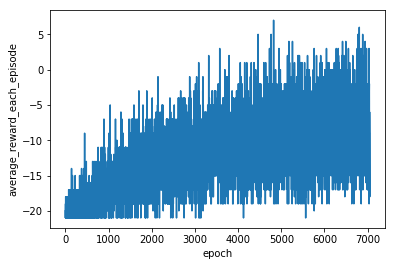

In [15]:
plt.plot(range(epoch), average_reward)
plt.xlabel('epoch')
plt.ylabel('average_reward_each_episode')

Personal commnent on the second problem: 
It is hard to train the Pong game (adjust its hyperparameters to get the convergence result), because its state_size is large. The above figure is what I got with constant baseline and learning rate 1e-3. The line goes up and down means the model is at least learning. It does not lead to the optimal result may be due to the time limit. Training the Pong game needs to do a lot of experiments, and the above result is the best I got, even though it does not lead to convergence. My number of epoch is set to be 10000, but I only plotted around the first 7000 result/epochs because I did not finish training.